In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sol = pd.read_csv('SampleSubmission.csv')

In [4]:
print(train.shape)
print(test.shape)

(4990, 13)
(3532, 12)


In [5]:
train.head()

,Item_ID,Store_ID,Item_Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type,Item_Store_Returns
0,DRA12,BABATUNJI010,DRA12_BABATUNJI010,11.6,Low Sugar,0.068535,Soft Drinks,357.54,2005,NaN,Cluster 3,Grocery Store,709.08
1,DRA12,BABATUNJI013,DRA12_BABATUNJI013,11.6,Low Sugar,0.040912,Soft Drinks,355.79,1994,High,Cluster 3,Supermarket Type1,6381.69
2,DRA12,BABATUNJI017,DRA12_BABATUNJI017,11.6,Low Sugar,0.041178,Soft Drinks,350.79,2014,NaN,Cluster 2,Supermarket Type1,6381.69
3,DRA12,BABATUNJI018,DRA12_BABATUNJI018,11.6,Low Sugar,0.041113,Soft Drinks,355.04,2016,Medium,Cluster 3,Supermarket Type2,2127.23
4,DRA12,BABATUNJI035,DRA12_BABATUNJI035,11.6,Ultra Low Sugar,0.000000,Soft Drinks,354.79,2011,Small,Cluster 2,Supermarket Type1,2481.77


In [6]:
test.head()

,Item_ID,Store_ID,Item_Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type
0,DRA59,BABATUNJI010,DRA59_BABATUNJI010,8.270,Normal Sugar,0.214125,Soft Drinks,459.98,2005,NaN,Cluster 3,Grocery Store
1,DRA59,BABATUNJI013,DRA59_BABATUNJI013,8.270,Normal Sugar,0.127821,Soft Drinks,464.98,1994,High,Cluster 3,Supermarket Type1
2,DRB01,BABATUNJI013,DRB01_BABATUNJI013,7.390,Low Sugar,0.082171,Soft Drinks,477.38,1994,High,Cluster 3,Supermarket Type1
3,DRB13,BABATUNJI010,DRB13_BABATUNJI010,6.115,Normal Sugar,0.011791,Soft Drinks,472.63,2005,NaN,Cluster 3,Grocery Store
4,DRB13,BABATUNJI013,DRB13_BABATUNJI013,6.115,Normal Sugar,0.007038,Soft Drinks,473.13,1994,High,Cluster 3,Supermarket Type1


In [7]:
sol.head()

,Item_Store_ID,Item_Store_Returns
0,DRA59_BABATUNJI010,100
1,DRA59_BABATUNJI013,100
2,DRB01_BABATUNJI013,100
3,DRB13_BABATUNJI010,100
4,DRB13_BABATUNJI013,100


In [8]:
sol.shape

(3532, 2)

In [9]:
submit = test[['Item_Store_ID']]

In [10]:
submit.shape

(3532, 1)

In [11]:
print(train['Item_Store_ID'].nunique())
print(test['Item_Store_ID'].nunique())

4990
3532


In [12]:
train.drop(['Item_Store_ID','Item_ID'], axis = 1, inplace = True)
test.drop(['Item_Store_ID','Item_ID'], axis = 1, inplace = True)

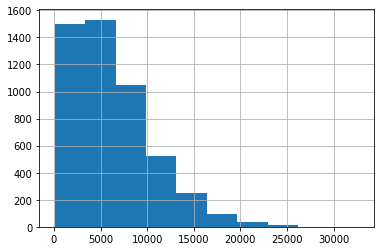

In [13]:
train['Item_Store_Returns'].hist()

In [14]:
# train['Item_Store_Returns'] = np.log1p(train['Item_Store_Returns'])

In [15]:
# sns.distplot(np.exp(np.log1p(train['Item_Store_Returns'])))

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store_ID             4990 non-null   object 
 1   Item_Weight          4188 non-null   float64
 2   Item_Sugar_Content   4990 non-null   object 
 3   Item_Visibility      4990 non-null   float64
 4   Item_Type            4990 non-null   object 
 5   Item_Price           4990 non-null   float64
 6   Store_Start_Year     4990 non-null   int64  
 7   Store_Size           3540 non-null   object 
 8   Store_Location_Type  4990 non-null   object 
 9   Store_Type           4990 non-null   object 
 10  Item_Store_Returns   4990 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 429.0+ KB


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3532 entries, 0 to 3531
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store_ID             3532 non-null   object 
 1   Item_Weight          2871 non-null   float64
 2   Item_Sugar_Content   3532 non-null   object 
 3   Item_Visibility      3532 non-null   float64
 4   Item_Type            3532 non-null   object 
 5   Item_Price           3532 non-null   float64
 6   Store_Start_Year     3532 non-null   int64  
 7   Store_Size           2573 non-null   object 
 8   Store_Location_Type  3532 non-null   object 
 9   Store_Type           3532 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 276.1+ KB


### Replacing Missing values

In [18]:
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace = True)
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace = True)

In [19]:
train['Store_Size'].value_counts()

Medium    1582
Small     1364
High       594
Name: Store_Size, dtype: int64

In [20]:
test['Store_Size'].value_counts()

Medium    1211
Small     1024
High       338
Name: Store_Size, dtype: int64

In [21]:
train['Store_Size'].fillna(train['Store_Size'].mode()[0], inplace = True)
test['Store_Size'].fillna(test['Store_Size'].mode()[0], inplace = True)

In [22]:
from datetime import datetime as dt

In [23]:
train['Store_Start_Year'] = dt.today().year - train['Store_Start_Year']
test['Store_Start_Year'] = dt.today().year - test['Store_Start_Year']

In [24]:
train['Store_Start_Year'] = train['Store_Start_Year'].astype('float')
test['Store_Start_Year'] = test['Store_Start_Year'].astype('float')

In [25]:
# sns.heatmap(train.corr(), annot = True)

In [26]:
train['sqrt_Item_Price'] = np.sqrt(train['Item_Price'])
test['sqrt_Item_Price'] = np.sqrt(test['Item_Price'])


train['cross_Item_weight'] = train['Item_Price'] * train['Item_Weight']
test['cross_Item_weight'] = test['Item_Price'] * test['Item_Weight']

train['Cross_Item_visibility_weight'] = train['Item_Price'] * train['Item_Weight'] * train['Item_Visibility']
test['Cross_Item_visibility_weight'] = test['Item_Price'] * test['Item_Weight'] * test['Item_Visibility']

In [27]:
data = train.drop('Item_Store_Returns', axis = 1)
target = train['Item_Store_Returns']

In [28]:
print(data.shape)
print(target.shape)

(4990, 13)
(4990,)


In [29]:
data['Store_ID'].nunique()

10

In [30]:
data['Item_Sugar_Content'].unique()

array(['Low Sugar', 'Ultra Low Sugar', 'Normal Sugar'], dtype=object)

In [31]:
data['Item_Type'].unique()

array(['Soft Drinks', 'Dairy', 'Hard Drinks', 'Canned', 'Frozen Foods',
       'Fruits and Vegetables', 'Snack Foods', 'Baking Goods',
       'Starchy Foods', 'Meat', 'Seafood', 'Breakfast', 'Breads',
       'Health and Hygiene', 'Household', 'Others'], dtype=object)

In [32]:
data['Store_Size'].unique()

array(['Medium', 'High', 'Small'], dtype=object)

In [33]:
data['Store_Location_Type'].unique()

array(['Cluster 3', 'Cluster 2', 'Cluster 1'], dtype=object)

In [34]:
data['Store_Type'].unique()

array(['Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
       'Supermarket Type3'], dtype=object)

In [35]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

In [36]:
data['Item_Sugar_Content'] = oe.fit_transform(data.Item_Sugar_Content.values.reshape(-1, 1))
test['Item_Sugar_Content'] = oe.fit_transform(test.Item_Sugar_Content.values.reshape(-1, 1))

In [37]:
data['Store_Size'] = oe.fit_transform(data.Store_Size.values.reshape(-1, 1))
test['Store_Size'] = oe.fit_transform(test.Store_Size.values.reshape(-1, 1))

In [38]:
dummy1 = pd.get_dummies(data['Store_ID'],prefix = 'Store_ID' )
dummy2 = pd.get_dummies(test['Store_ID'],prefix = 'Store_ID' )

data = pd.concat([data, dummy1], axis = 1)
test = pd.concat([test, dummy2], axis = 1)

data.drop('Store_ID', axis = 1, inplace = True)
test.drop('Store_ID', axis = 1, inplace = True)

In [39]:
dummy1 = pd.get_dummies(data['Item_Type'],prefix = 'Item_Type' )
dummy2 = pd.get_dummies(test['Item_Type'],prefix = 'Item_Type' )

data = pd.concat([data, dummy1], axis = 1)
test = pd.concat([test, dummy2], axis = 1)

data.drop('Item_Type', axis = 1, inplace = True)
test.drop('Item_Type', axis = 1, inplace = True)

In [40]:
dummy1 = pd.get_dummies(data['Store_Location_Type'],prefix = 'Loc_Type' )
dummy2 = pd.get_dummies(test['Store_Location_Type'],prefix = 'Loc_Type' )

data = pd.concat([data, dummy1], axis = 1)
test = pd.concat([test, dummy2], axis = 1)

data.drop('Store_Location_Type', axis = 1, inplace = True)
test.drop('Store_Location_Type', axis = 1, inplace = True)

In [41]:
dummy1 = pd.get_dummies(data['Store_Type'],prefix = 'Store_Type' )
dummy2 = pd.get_dummies(test['Store_Type'],prefix = 'Store_Type' )

data = pd.concat([data, dummy1], axis = 1)
test = pd.concat([test, dummy2], axis = 1)

data.drop('Store_Type', axis = 1, inplace = True)
test.drop('Store_Type', axis = 1, inplace = True)

In [42]:
print(data.shape)
print(test.shape)

(4990, 42)
(3532, 42)


In [43]:
kf = KFold(n_splits=30)

In [44]:
lgb = LGBMRegressor(num_leaves=200, min_data_in_leaf=3,
                    objective='regression',
                    max_depth=-1,learning_rate=0.05, 
                    boosting_type='gbdt', 
                    feature_fraction=0.60,
                    lambda_l1=1,lambda_l2=1, 
                    metric='rmse', 
                    num_iterations=4000)

xgb = XGBRegressor(n_estimators = 5000, max_depth = 30, 
                     reg_lambda = 80,random_state = 30,
                     learning_rate=0.3, gamma = 1.5)

cat = CatBoostRegressor(iterations = 50, depth = 3, learning_rate = 0.05, loss_function = 'RMSE')

# cat = CatBoostRegressor(n_estimators=5000,max_depth=5,eval_metric='RMSE',reg_lambda=50,random_state=101)

In [45]:
lgb_scores = []
lgb_test_pred = np.zeros(len(test))
lgb_train_pred = np.zeros(len(train))

for fold,(tr_in,te_in) in enumerate(kf.split(data)):
    
    print(f"==================================Fold{fold}=============================================")
    X_train,X_test = data.iloc[tr_in],data.iloc[te_in]
    y_train,y_test = target.iloc[tr_in],target.iloc[te_in]
    
    lgb.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_test,y_test)],
            early_stopping_rounds = 500)
    
    lgb_scores.append(np.sqrt(mse(y_test,lgb.predict(X_test))))
    
    lgb_train_pred += lgb.predict(data)
    lgb_test_pred += lgb.predict(test)

==================================Fold0=============================================


C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 4300.88	valid_1's rmse: 4408.98
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4164.24	valid_1's rmse: 4309.5
[3]	training's rmse: 4036.04	valid_1's rmse: 4220.29
[4]	training's rmse: 3916.7	valid_1's rmse: 4134.29
[5]	training's rmse: 3804.62	valid_1's rmse: 4053.33
[6]	training's rmse: 3698.46	valid_1's rmse: 3985.1
[7]	training's rmse: 3600.81	valid_1's rmse: 3922.92
[8]	training's rmse: 3503.65	valid_1's rmse: 3868.08
[9]	training's rmse: 3412.35	valid_1's rmse: 3823.34
[10]	training's rmse: 3328.61	valid_1's rmse: 3773.57
[11]	training's rmse: 3248.12	valid_1's rmse: 3734.86
[12]	training's rmse: 3172.76	valid_1's rmse: 3704.98
[13]	training's rmse: 3100.02	valid_1's rmse: 3670.12
[14]	training's rmse: 3031.39	valid_1's rmse: 3638.12
[15]	training's rmse: 2966.36	valid_1's rmse: 3622.01
[16]	training's rmse: 2905.13	valid_1's rmse: 3599.13
[17]	training's rmse: 2848.86	valid_1's rmse: 3577.23
[18]	training's rmse: 2797.73	va

[167]	training's rmse: 1016.53	valid_1's rmse: 3481.53
[168]	training's rmse: 1012.67	valid_1's rmse: 3484.6
[169]	training's rmse: 1009.03	valid_1's rmse: 3484.23
[170]	training's rmse: 1003.97	valid_1's rmse: 3483.93
[171]	training's rmse: 1000.51	valid_1's rmse: 3483.57
[172]	training's rmse: 995.402	valid_1's rmse: 3486.05
[173]	training's rmse: 991.738	valid_1's rmse: 3486.54
[174]	training's rmse: 987.622	valid_1's rmse: 3485.04
[175]	training's rmse: 984.606	valid_1's rmse: 3485.33
[176]	training's rmse: 979.944	valid_1's rmse: 3487.5
[177]	training's rmse: 974.619	valid_1's rmse: 3488.2
[178]	training's rmse: 969.941	valid_1's rmse: 3487.95
[179]	training's rmse: 965.592	valid_1's rmse: 3488.25
[180]	training's rmse: 962.141	valid_1's rmse: 3490.93
[181]	training's rmse: 956.704	valid_1's rmse: 3489.48
[182]	training's rmse: 951.886	valid_1's rmse: 3488.18
[183]	training's rmse: 945.848	valid_1's rmse: 3490.1
[184]	training's rmse: 941.667	valid_1's rmse: 3489.94
[185]	training

[329]	training's rmse: 544.87	valid_1's rmse: 3521.1
[330]	training's rmse: 543.498	valid_1's rmse: 3521.16
[331]	training's rmse: 541.46	valid_1's rmse: 3521.85
[332]	training's rmse: 538.848	valid_1's rmse: 3521.78
[333]	training's rmse: 536.55	valid_1's rmse: 3522.56
[334]	training's rmse: 535.644	valid_1's rmse: 3523.17
[335]	training's rmse: 533.441	valid_1's rmse: 3524.07
[336]	training's rmse: 532.283	valid_1's rmse: 3524.49
[337]	training's rmse: 529.688	valid_1's rmse: 3523.99
[338]	training's rmse: 527.778	valid_1's rmse: 3524.23
[339]	training's rmse: 525.871	valid_1's rmse: 3524.9
[340]	training's rmse: 523.784	valid_1's rmse: 3525.59
[341]	training's rmse: 521.599	valid_1's rmse: 3525.75
[342]	training's rmse: 520.116	valid_1's rmse: 3526.77
[343]	training's rmse: 517.637	valid_1's rmse: 3526.42
[344]	training's rmse: 515.427	valid_1's rmse: 3526.88
[345]	training's rmse: 513.012	valid_1's rmse: 3526.93
[346]	training's rmse: 511.858	valid_1's rmse: 3527.17
[347]	training'

[485]	training's rmse: 316.966	valid_1's rmse: 3546.55
[486]	training's rmse: 315.651	valid_1's rmse: 3546.66
[487]	training's rmse: 314.26	valid_1's rmse: 3546.44
[488]	training's rmse: 313.448	valid_1's rmse: 3546.47
[489]	training's rmse: 311.638	valid_1's rmse: 3546.6
[490]	training's rmse: 310.914	valid_1's rmse: 3546.84
[491]	training's rmse: 309.988	valid_1's rmse: 3547.15
[492]	training's rmse: 308.828	valid_1's rmse: 3546.97
[493]	training's rmse: 308.159	valid_1's rmse: 3546.93
[494]	training's rmse: 307.393	valid_1's rmse: 3547.25
[495]	training's rmse: 306.45	valid_1's rmse: 3547.15
[496]	training's rmse: 305.315	valid_1's rmse: 3547.15
[497]	training's rmse: 304.332	valid_1's rmse: 3547.51
[498]	training's rmse: 302.707	valid_1's rmse: 3547.32
[499]	training's rmse: 301.834	valid_1's rmse: 3547.28
[500]	training's rmse: 301.204	valid_1's rmse: 3547.26
[501]	training's rmse: 300.33	valid_1's rmse: 3547.57
[502]	training's rmse: 299.713	valid_1's rmse: 3547.85
[503]	training

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3109.67	valid_1's rmse: 3320.39
[14]	training's rmse: 3041.4	valid_1's rmse: 3286.8
[15]	training's rmse: 2977.18	valid_1's rmse: 3255.78
[16]	training's rmse: 2914.37	valid_1's rmse: 3224.11
[17]	training's rmse: 2857.53	valid_1's rmse: 3191.1
[18]	training's rmse: 2805.01	valid_1's rmse: 3172.08
[19]	training's rmse: 2751.06	valid_1's rmse: 3157.99
[20]	training's rmse: 2705.16	valid_1's rmse: 3133.74
[21]	training's rmse: 2658.77	valid_1's rmse: 3112.67
[22]	training's rmse: 2614.17	valid_1's rmse: 3098.3
[23]	training's rmse: 2571.79	valid_1's rmse: 3085.48
[24]	training's rmse: 2532.29	valid_1's rmse: 3073.99
[25]	training's rmse: 2492.45	valid_1's rmse: 3054.03
[26]	training's rmse: 2455.79	valid_1's rmse: 3044.41
[27]	training's rmse: 2419.68	valid_1's rmse: 3035.78
[28]	training's rmse: 2387.39	valid_1's rmse: 3028.23
[29]	training's rmse: 2355.28	valid_1's rmse: 3016.1
[30]	training's rmse: 2328.67	valid_1's rmse: 3012.15
[31]	training's rmse: 2299.1	val

[169]	training's rmse: 1007.14	valid_1's rmse: 3012.15
[170]	training's rmse: 1003.14	valid_1's rmse: 3012.44
[171]	training's rmse: 998.586	valid_1's rmse: 3013.74
[172]	training's rmse: 993.527	valid_1's rmse: 3013.71
[173]	training's rmse: 989.593	valid_1's rmse: 3013.7
[174]	training's rmse: 986.213	valid_1's rmse: 3013.58
[175]	training's rmse: 981.746	valid_1's rmse: 3014.77
[176]	training's rmse: 978.389	valid_1's rmse: 3013.96
[177]	training's rmse: 973.643	valid_1's rmse: 3013.37
[178]	training's rmse: 969.083	valid_1's rmse: 3012.45
[179]	training's rmse: 965.177	valid_1's rmse: 3013.15
[180]	training's rmse: 961.47	valid_1's rmse: 3012.92
[181]	training's rmse: 958.725	valid_1's rmse: 3013.57
[182]	training's rmse: 954.807	valid_1's rmse: 3014.45
[183]	training's rmse: 951.758	valid_1's rmse: 3015.6
[184]	training's rmse: 946.49	valid_1's rmse: 3014.21
[185]	training's rmse: 942.996	valid_1's rmse: 3014.97
[186]	training's rmse: 937.387	valid_1's rmse: 3015.87
[187]	training

[319]	training's rmse: 558.835	valid_1's rmse: 3044.65
[320]	training's rmse: 557.11	valid_1's rmse: 3044.29
[321]	training's rmse: 554.901	valid_1's rmse: 3044.83
[322]	training's rmse: 553.611	valid_1's rmse: 3045.3
[323]	training's rmse: 551.714	valid_1's rmse: 3045.24
[324]	training's rmse: 550.164	valid_1's rmse: 3045.41
[325]	training's rmse: 547.864	valid_1's rmse: 3045.31
[326]	training's rmse: 546.078	valid_1's rmse: 3045.78
[327]	training's rmse: 544.637	valid_1's rmse: 3045.86
[328]	training's rmse: 543.424	valid_1's rmse: 3045.46
[329]	training's rmse: 541.332	valid_1's rmse: 3045.22
[330]	training's rmse: 539.016	valid_1's rmse: 3044.95
[331]	training's rmse: 536.842	valid_1's rmse: 3044.99
[332]	training's rmse: 535.34	valid_1's rmse: 3044.82
[333]	training's rmse: 533.466	valid_1's rmse: 3045.72
[334]	training's rmse: 530.799	valid_1's rmse: 3046.8
[335]	training's rmse: 528.675	valid_1's rmse: 3045.96
[336]	training's rmse: 526.506	valid_1's rmse: 3046.26
[337]	training

[475]	training's rmse: 320.098	valid_1's rmse: 3071.27
[476]	training's rmse: 319.35	valid_1's rmse: 3071.93
[477]	training's rmse: 318.366	valid_1's rmse: 3072.31
[478]	training's rmse: 317.47	valid_1's rmse: 3072.1
[479]	training's rmse: 316.212	valid_1's rmse: 3072.73
[480]	training's rmse: 315.647	valid_1's rmse: 3072.68
[481]	training's rmse: 314.484	valid_1's rmse: 3073.28
[482]	training's rmse: 313.161	valid_1's rmse: 3073.67
[483]	training's rmse: 311.786	valid_1's rmse: 3073.94
[484]	training's rmse: 310.921	valid_1's rmse: 3073.93
[485]	training's rmse: 309.594	valid_1's rmse: 3073.58
[486]	training's rmse: 308.504	valid_1's rmse: 3073.74
[487]	training's rmse: 307.245	valid_1's rmse: 3073.7
[488]	training's rmse: 306.396	valid_1's rmse: 3073.78
[489]	training's rmse: 305.672	valid_1's rmse: 3073.78
[490]	training's rmse: 304.097	valid_1's rmse: 3073.54
[491]	training's rmse: 303.332	valid_1's rmse: 3073.33
[492]	training's rmse: 301.997	valid_1's rmse: 3073.16
[493]	training

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[6]	training's rmse: 3701.95	valid_1's rmse: 3779.64
[7]	training's rmse: 3604.08	valid_1's rmse: 3709.78
[8]	training's rmse: 3507.94	valid_1's rmse: 3648.31
[9]	training's rmse: 3416.71	valid_1's rmse: 3591.75
[10]	training's rmse: 3332.85	valid_1's rmse: 3552.68
[11]	training's rmse: 3252.8	valid_1's rmse: 3504.51
[12]	training's rmse: 3176.02	valid_1's rmse: 3461.44
[13]	training's rmse: 3102.67	valid_1's rmse: 3419
[14]	training's rmse: 3033.13	valid_1's rmse: 3382.16
[15]	training's rmse: 2966.87	valid_1's rmse: 3358.71
[16]	training's rmse: 2905.75	valid_1's rmse: 3326.57
[17]	training's rmse: 2848.11	valid_1's rmse: 3307.85
[18]	training's rmse: 2795	valid_1's rmse: 3294.49
[19]	training's rmse: 2742.73	valid_1's rmse: 3288.33
[20]	training's rmse: 2697.98	valid_1's rmse: 3270.59
[21]	training's rmse: 2652.98	valid_1's rmse: 3257.89
[22]	training's rmse: 2609.89	valid_1's rmse: 3249.66
[23]	training's rmse: 2568.75	valid_1's rmse: 3241.36
[24]	training's rmse: 2531.15	valid_1'

[164]	training's rmse: 1052.19	valid_1's rmse: 3381.46
[165]	training's rmse: 1048.83	valid_1's rmse: 3380.73
[166]	training's rmse: 1044.69	valid_1's rmse: 3381.3
[167]	training's rmse: 1039.64	valid_1's rmse: 3382.84
[168]	training's rmse: 1034.44	valid_1's rmse: 3382.27
[169]	training's rmse: 1030.9	valid_1's rmse: 3385.25
[170]	training's rmse: 1026.23	valid_1's rmse: 3385.93
[171]	training's rmse: 1021.11	valid_1's rmse: 3387.35
[172]	training's rmse: 1015.85	valid_1's rmse: 3389.14
[173]	training's rmse: 1010.56	valid_1's rmse: 3393.28
[174]	training's rmse: 1006.23	valid_1's rmse: 3393.57
[175]	training's rmse: 1001.02	valid_1's rmse: 3394.5
[176]	training's rmse: 997.523	valid_1's rmse: 3393.33
[177]	training's rmse: 993.41	valid_1's rmse: 3393.85
[178]	training's rmse: 990.429	valid_1's rmse: 3395.04
[179]	training's rmse: 985.633	valid_1's rmse: 3397.35
[180]	training's rmse: 979.886	valid_1's rmse: 3401.47
[181]	training's rmse: 975.016	valid_1's rmse: 3404.51
[182]	training

[328]	training's rmse: 546.976	valid_1's rmse: 3456.97
[329]	training's rmse: 545.377	valid_1's rmse: 3456.98
[330]	training's rmse: 544.358	valid_1's rmse: 3456.85
[331]	training's rmse: 542.413	valid_1's rmse: 3457.42
[332]	training's rmse: 539.39	valid_1's rmse: 3458.76
[333]	training's rmse: 537.183	valid_1's rmse: 3458.71
[334]	training's rmse: 535.768	valid_1's rmse: 3459.21
[335]	training's rmse: 534.301	valid_1's rmse: 3459.33
[336]	training's rmse: 532.283	valid_1's rmse: 3458.35
[337]	training's rmse: 530.772	valid_1's rmse: 3457.83
[338]	training's rmse: 528.5	valid_1's rmse: 3457.66
[339]	training's rmse: 526.194	valid_1's rmse: 3458.4
[340]	training's rmse: 524.026	valid_1's rmse: 3459.33
[341]	training's rmse: 521.934	valid_1's rmse: 3459.39
[342]	training's rmse: 519.109	valid_1's rmse: 3459.45
[343]	training's rmse: 516.401	valid_1's rmse: 3459.92
[344]	training's rmse: 515.176	valid_1's rmse: 3460.25
[345]	training's rmse: 512.417	valid_1's rmse: 3460.44
[346]	training

[496]	training's rmse: 302.162	valid_1's rmse: 3487.07
[497]	training's rmse: 301.31	valid_1's rmse: 3486.61
[498]	training's rmse: 300.355	valid_1's rmse: 3486.45
[499]	training's rmse: 299.828	valid_1's rmse: 3486.59
[500]	training's rmse: 298.737	valid_1's rmse: 3486.6
[501]	training's rmse: 297.891	valid_1's rmse: 3486.7
[502]	training's rmse: 297.02	valid_1's rmse: 3486.66
[503]	training's rmse: 295.883	valid_1's rmse: 3486.56
[504]	training's rmse: 295.134	valid_1's rmse: 3486.27
[505]	training's rmse: 294.519	valid_1's rmse: 3486.31
[506]	training's rmse: 293.664	valid_1's rmse: 3486.13
[507]	training's rmse: 292.921	valid_1's rmse: 3486.21
[508]	training's rmse: 292.428	valid_1's rmse: 3486.13
[509]	training's rmse: 291.613	valid_1's rmse: 3486.15
[510]	training's rmse: 291.054	valid_1's rmse: 3486.61
[511]	training's rmse: 289.852	valid_1's rmse: 3487.16
[512]	training's rmse: 288.926	valid_1's rmse: 3486.95
[513]	training's rmse: 287.626	valid_1's rmse: 3487.12
[514]	training

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3102.64	valid_1's rmse: 3494.73
[14]	training's rmse: 3034.52	valid_1's rmse: 3454.29
[15]	training's rmse: 2968.73	valid_1's rmse: 3414.35
[16]	training's rmse: 2904.43	valid_1's rmse: 3390.3
[17]	training's rmse: 2846.06	valid_1's rmse: 3355.78
[18]	training's rmse: 2793.86	valid_1's rmse: 3330.37
[19]	training's rmse: 2739.55	valid_1's rmse: 3300.52
[20]	training's rmse: 2694.81	valid_1's rmse: 3283.24
[21]	training's rmse: 2648.96	valid_1's rmse: 3261.47
[22]	training's rmse: 2606.76	valid_1's rmse: 3238.2
[23]	training's rmse: 2564.29	valid_1's rmse: 3222.67
[24]	training's rmse: 2526.91	valid_1's rmse: 3205.09
[25]	training's rmse: 2486.39	valid_1's rmse: 3188.3
[26]	training's rmse: 2449.04	valid_1's rmse: 3175.81
[27]	training's rmse: 2414.87	valid_1's rmse: 3164.89
[28]	training's rmse: 2382.1	valid_1's rmse: 3161.18
[29]	training's rmse: 2351.12	valid_1's rmse: 3152.74
[30]	training's rmse: 2323.36	valid_1's rmse: 3144.39
[31]	training's rmse: 2293.19	v

[176]	training's rmse: 967.053	valid_1's rmse: 3186.86
[177]	training's rmse: 962.352	valid_1's rmse: 3189.28
[178]	training's rmse: 956.834	valid_1's rmse: 3188.77
[179]	training's rmse: 952.457	valid_1's rmse: 3189.15
[180]	training's rmse: 949.116	valid_1's rmse: 3189.28
[181]	training's rmse: 944.415	valid_1's rmse: 3188.74
[182]	training's rmse: 941.413	valid_1's rmse: 3188.84
[183]	training's rmse: 938.232	valid_1's rmse: 3189.12
[184]	training's rmse: 935.562	valid_1's rmse: 3189.79
[185]	training's rmse: 931.163	valid_1's rmse: 3190.8
[186]	training's rmse: 927.612	valid_1's rmse: 3191.84
[187]	training's rmse: 923.096	valid_1's rmse: 3190.29
[188]	training's rmse: 920.36	valid_1's rmse: 3190.59
[189]	training's rmse: 917.187	valid_1's rmse: 3191.22
[190]	training's rmse: 913.603	valid_1's rmse: 3190.16
[191]	training's rmse: 909.571	valid_1's rmse: 3193.19
[192]	training's rmse: 909.113	valid_1's rmse: 3193.38
[193]	training's rmse: 904.695	valid_1's rmse: 3193.44
[194]	traini

[348]	training's rmse: 507.468	valid_1's rmse: 3227.3
[349]	training's rmse: 505.262	valid_1's rmse: 3227.73
[350]	training's rmse: 502.817	valid_1's rmse: 3228.08
[351]	training's rmse: 501.527	valid_1's rmse: 3228.39
[352]	training's rmse: 499.571	valid_1's rmse: 3228.38
[353]	training's rmse: 497.662	valid_1's rmse: 3228.23
[354]	training's rmse: 495.938	valid_1's rmse: 3228.04
[355]	training's rmse: 494.022	valid_1's rmse: 3226.81
[356]	training's rmse: 492.42	valid_1's rmse: 3226.31
[357]	training's rmse: 490.84	valid_1's rmse: 3225.96
[358]	training's rmse: 489.358	valid_1's rmse: 3226.21
[359]	training's rmse: 487.262	valid_1's rmse: 3226.11
[360]	training's rmse: 485.695	valid_1's rmse: 3226.07
[361]	training's rmse: 484.133	valid_1's rmse: 3226.18
[362]	training's rmse: 481.923	valid_1's rmse: 3227.75
[363]	training's rmse: 480.416	valid_1's rmse: 3228.42
[364]	training's rmse: 478.162	valid_1's rmse: 3228.66
[365]	training's rmse: 476.717	valid_1's rmse: 3229.11
[366]	trainin

[515]	training's rmse: 283.402	valid_1's rmse: 3238.34
[516]	training's rmse: 282.633	valid_1's rmse: 3238.18
[517]	training's rmse: 281.736	valid_1's rmse: 3238.43
[518]	training's rmse: 280.415	valid_1's rmse: 3239.1
[519]	training's rmse: 278.882	valid_1's rmse: 3239.3
[520]	training's rmse: 277.421	valid_1's rmse: 3239.23
[521]	training's rmse: 276.586	valid_1's rmse: 3239.07
[522]	training's rmse: 275.53	valid_1's rmse: 3238.95
[523]	training's rmse: 274.384	valid_1's rmse: 3239.08
[524]	training's rmse: 273.534	valid_1's rmse: 3239.01
[525]	training's rmse: 272.8	valid_1's rmse: 3239.11
[526]	training's rmse: 271.503	valid_1's rmse: 3239.05
[527]	training's rmse: 270.405	valid_1's rmse: 3239.17
[528]	training's rmse: 269.707	valid_1's rmse: 3238.89
[529]	training's rmse: 269.076	valid_1's rmse: 3238.89
[530]	training's rmse: 268.105	valid_1's rmse: 3238.84
[531]	training's rmse: 267.22	valid_1's rmse: 3238.87
[532]	training's rmse: 265.774	valid_1's rmse: 3238.88
[533]	training's

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[11]	training's rmse: 3251.5	valid_1's rmse: 3412.71
[12]	training's rmse: 3176.3	valid_1's rmse: 3357.49
[13]	training's rmse: 3103.49	valid_1's rmse: 3303.29
[14]	training's rmse: 3035.04	valid_1's rmse: 3260.84
[15]	training's rmse: 2971.05	valid_1's rmse: 3225.22
[16]	training's rmse: 2908.63	valid_1's rmse: 3176.93
[17]	training's rmse: 2852.66	valid_1's rmse: 3143.22
[18]	training's rmse: 2800.82	valid_1's rmse: 3113.67
[19]	training's rmse: 2750.16	valid_1's rmse: 3082.34
[20]	training's rmse: 2704.24	valid_1's rmse: 3057.44
[21]	training's rmse: 2657.36	valid_1's rmse: 3033.58
[22]	training's rmse: 2615.24	valid_1's rmse: 3013.43
[23]	training's rmse: 2574.98	valid_1's rmse: 2991.93
[24]	training's rmse: 2536.68	valid_1's rmse: 2976.01
[25]	training's rmse: 2497.87	valid_1's rmse: 2960.55
[26]	training's rmse: 2460.94	valid_1's rmse: 2952.56
[27]	training's rmse: 2426.87	valid_1's rmse: 2946.85
[28]	training's rmse: 2394.97	valid_1's rmse: 2936.32
[29]	training's rmse: 2362.04

[177]	training's rmse: 974.142	valid_1's rmse: 2998.22
[178]	training's rmse: 970.059	valid_1's rmse: 3000.02
[179]	training's rmse: 965.606	valid_1's rmse: 3001.18
[180]	training's rmse: 961.123	valid_1's rmse: 2999.91
[181]	training's rmse: 957.604	valid_1's rmse: 3001.65
[182]	training's rmse: 953.157	valid_1's rmse: 3002.15
[183]	training's rmse: 948.966	valid_1's rmse: 3002.59
[184]	training's rmse: 945.403	valid_1's rmse: 3002.65
[185]	training's rmse: 940.867	valid_1's rmse: 3003.6
[186]	training's rmse: 935.115	valid_1's rmse: 3004.58
[187]	training's rmse: 931.344	valid_1's rmse: 3006
[188]	training's rmse: 925.42	valid_1's rmse: 3007.16
[189]	training's rmse: 922.313	valid_1's rmse: 3005.47
[190]	training's rmse: 918.528	valid_1's rmse: 3007.15
[191]	training's rmse: 914.218	valid_1's rmse: 3006.29
[192]	training's rmse: 913.641	valid_1's rmse: 3006.88
[193]	training's rmse: 908.901	valid_1's rmse: 3006.68
[194]	training's rmse: 905.251	valid_1's rmse: 3005.29
[195]	training'

[344]	training's rmse: 500.824	valid_1's rmse: 3076.73
[345]	training's rmse: 499.198	valid_1's rmse: 3076.83
[346]	training's rmse: 497.504	valid_1's rmse: 3077.52
[347]	training's rmse: 494.85	valid_1's rmse: 3078.7
[348]	training's rmse: 493.659	valid_1's rmse: 3078.19
[349]	training's rmse: 491.939	valid_1's rmse: 3077.93
[350]	training's rmse: 489.581	valid_1's rmse: 3077.18
[351]	training's rmse: 487.058	valid_1's rmse: 3078.54
[352]	training's rmse: 484.025	valid_1's rmse: 3078.41
[353]	training's rmse: 482.381	valid_1's rmse: 3077.96
[354]	training's rmse: 480.696	valid_1's rmse: 3078.26
[355]	training's rmse: 479.086	valid_1's rmse: 3078.92
[356]	training's rmse: 476.071	valid_1's rmse: 3079.47
[357]	training's rmse: 473.939	valid_1's rmse: 3079.67
[358]	training's rmse: 471.113	valid_1's rmse: 3078.69
[359]	training's rmse: 468.466	valid_1's rmse: 3077.95
[360]	training's rmse: 467.196	valid_1's rmse: 3078.8
[361]	training's rmse: 465.009	valid_1's rmse: 3079.34
[362]	trainin

[509]	training's rmse: 275.404	valid_1's rmse: 3105.22
[510]	training's rmse: 274.24	valid_1's rmse: 3105.42
[511]	training's rmse: 273.086	valid_1's rmse: 3105.92
[512]	training's rmse: 272.16	valid_1's rmse: 3105.77
[513]	training's rmse: 271.309	valid_1's rmse: 3105.41
[514]	training's rmse: 270.487	valid_1's rmse: 3105.4
[515]	training's rmse: 269.697	valid_1's rmse: 3105.38
[516]	training's rmse: 268.681	valid_1's rmse: 3105.91
[517]	training's rmse: 267.303	valid_1's rmse: 3106.28
[518]	training's rmse: 265.968	valid_1's rmse: 3106.51
[519]	training's rmse: 265.357	valid_1's rmse: 3107.13
[520]	training's rmse: 264.74	valid_1's rmse: 3107.16
[521]	training's rmse: 264.096	valid_1's rmse: 3107.24
[522]	training's rmse: 263.317	valid_1's rmse: 3107.15
[523]	training's rmse: 262.691	valid_1's rmse: 3107.28
[524]	training's rmse: 261.68	valid_1's rmse: 3107.56
[525]	training's rmse: 260.873	valid_1's rmse: 3107.44
[526]	training's rmse: 260.195	valid_1's rmse: 3107.39
[527]	training'

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 4319.02	valid_1's rmse: 3854.14
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4183.87	valid_1's rmse: 3741.41
[3]	training's rmse: 4054.67	valid_1's rmse: 3639.84
[4]	training's rmse: 3935.09	valid_1's rmse: 3540.77
[5]	training's rmse: 3820.59	valid_1's rmse: 3453.03
[6]	training's rmse: 3713.98	valid_1's rmse: 3371.44
[7]	training's rmse: 3615.66	valid_1's rmse: 3287.66
[8]	training's rmse: 3520.4	valid_1's rmse: 3217.41
[9]	training's rmse: 3428.02	valid_1's rmse: 3158.07
[10]	training's rmse: 3344.46	valid_1's rmse: 3098.73
[11]	training's rmse: 3266.18	valid_1's rmse: 3048.24
[12]	training's rmse: 3188.02	valid_1's rmse: 2994.89
[13]	training's rmse: 3114.57	valid_1's rmse: 2945.58
[14]	training's rmse: 3045.49	valid_1's rmse: 2903.32
[15]	training's rmse: 2979.9	valid_1's rmse: 2867.84
[16]	training's rmse: 2917.42	valid_1's rmse: 2829.59
[17]	training's rmse: 2859.03	valid_1's rmse: 2803.28
[18]	training's rmse: 2807.24	v

[156]	training's rmse: 1073.66	valid_1's rmse: 2664.67
[157]	training's rmse: 1070.06	valid_1's rmse: 2665.84
[158]	training's rmse: 1065.13	valid_1's rmse: 2668.22
[159]	training's rmse: 1061.37	valid_1's rmse: 2668.69
[160]	training's rmse: 1057.1	valid_1's rmse: 2669.61
[161]	training's rmse: 1053.55	valid_1's rmse: 2670.32
[162]	training's rmse: 1050.51	valid_1's rmse: 2672.47
[163]	training's rmse: 1044.46	valid_1's rmse: 2673.23
[164]	training's rmse: 1038.8	valid_1's rmse: 2673.55
[165]	training's rmse: 1035.37	valid_1's rmse: 2673.82
[166]	training's rmse: 1029.78	valid_1's rmse: 2674.2
[167]	training's rmse: 1025.04	valid_1's rmse: 2673.64
[168]	training's rmse: 1019.36	valid_1's rmse: 2673.39
[169]	training's rmse: 1015.13	valid_1's rmse: 2674.04
[170]	training's rmse: 1010.26	valid_1's rmse: 2674.55
[171]	training's rmse: 1004.06	valid_1's rmse: 2675.14
[172]	training's rmse: 1000.57	valid_1's rmse: 2676.88
[173]	training's rmse: 995.353	valid_1's rmse: 2676.69
[174]	trainin

[309]	training's rmse: 583.422	valid_1's rmse: 2722.23
[310]	training's rmse: 580.605	valid_1's rmse: 2722.46
[311]	training's rmse: 578.049	valid_1's rmse: 2722.72
[312]	training's rmse: 574.875	valid_1's rmse: 2724.03
[313]	training's rmse: 573.336	valid_1's rmse: 2725.05
[314]	training's rmse: 571.525	valid_1's rmse: 2725.91
[315]	training's rmse: 568.508	valid_1's rmse: 2725.04
[316]	training's rmse: 566.344	valid_1's rmse: 2723.88
[317]	training's rmse: 564.877	valid_1's rmse: 2723.72
[318]	training's rmse: 562.295	valid_1's rmse: 2724.83
[319]	training's rmse: 559.246	valid_1's rmse: 2725.45
[320]	training's rmse: 557.309	valid_1's rmse: 2726.45
[321]	training's rmse: 554.656	valid_1's rmse: 2726.05
[322]	training's rmse: 552.995	valid_1's rmse: 2725.51
[323]	training's rmse: 551.018	valid_1's rmse: 2724.64
[324]	training's rmse: 548.631	valid_1's rmse: 2722.27
[325]	training's rmse: 546.04	valid_1's rmse: 2720.79
[326]	training's rmse: 543.584	valid_1's rmse: 2719.96
[327]	train

[471]	training's rmse: 316.447	valid_1's rmse: 2738.87
[472]	training's rmse: 315.017	valid_1's rmse: 2739.53
[473]	training's rmse: 314.2	valid_1's rmse: 2739.85
[474]	training's rmse: 313.188	valid_1's rmse: 2739.82
[475]	training's rmse: 312.055	valid_1's rmse: 2739.94
[476]	training's rmse: 310.827	valid_1's rmse: 2740.26
[477]	training's rmse: 309.671	valid_1's rmse: 2740.22
[478]	training's rmse: 308.448	valid_1's rmse: 2740.17
[479]	training's rmse: 306.605	valid_1's rmse: 2740.29
[480]	training's rmse: 305.435	valid_1's rmse: 2739.7
[481]	training's rmse: 303.832	valid_1's rmse: 2740.09
[482]	training's rmse: 302.517	valid_1's rmse: 2739.96
[483]	training's rmse: 301.397	valid_1's rmse: 2739.36
[484]	training's rmse: 299.976	valid_1's rmse: 2739.5
[485]	training's rmse: 298.902	valid_1's rmse: 2739.26
[486]	training's rmse: 298.135	valid_1's rmse: 2738.79
[487]	training's rmse: 297.228	valid_1's rmse: 2738.9
[488]	training's rmse: 296.023	valid_1's rmse: 2739.05
[489]	training'

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[3]	training's rmse: 4044.11	valid_1's rmse: 4013.54
[4]	training's rmse: 3923.53	valid_1's rmse: 3937.51
[5]	training's rmse: 3809.2	valid_1's rmse: 3865.29
[6]	training's rmse: 3702.99	valid_1's rmse: 3801.57
[7]	training's rmse: 3605.87	valid_1's rmse: 3742.75
[8]	training's rmse: 3510.89	valid_1's rmse: 3690.45
[9]	training's rmse: 3419.46	valid_1's rmse: 3641.8
[10]	training's rmse: 3336.57	valid_1's rmse: 3594.36
[11]	training's rmse: 3257.27	valid_1's rmse: 3552.02
[12]	training's rmse: 3178.58	valid_1's rmse: 3517.13
[13]	training's rmse: 3104.39	valid_1's rmse: 3482.65
[14]	training's rmse: 3035.43	valid_1's rmse: 3449.44
[15]	training's rmse: 2972.02	valid_1's rmse: 3426.28
[16]	training's rmse: 2909.91	valid_1's rmse: 3402.15
[17]	training's rmse: 2850.7	valid_1's rmse: 3371.23
[18]	training's rmse: 2798.71	valid_1's rmse: 3338.23
[19]	training's rmse: 2745.75	valid_1's rmse: 3319.82
[20]	training's rmse: 2700.29	valid_1's rmse: 3295.44
[21]	training's rmse: 2653.04	valid_1

[160]	training's rmse: 1075.54	valid_1's rmse: 3065.57
[161]	training's rmse: 1069.17	valid_1's rmse: 3062.34
[162]	training's rmse: 1064.31	valid_1's rmse: 3058.85
[163]	training's rmse: 1059.4	valid_1's rmse: 3059.21
[164]	training's rmse: 1055.47	valid_1's rmse: 3059.42
[165]	training's rmse: 1051.83	valid_1's rmse: 3060.4
[166]	training's rmse: 1044.99	valid_1's rmse: 3059.72
[167]	training's rmse: 1040.41	valid_1's rmse: 3059.09
[168]	training's rmse: 1036.1	valid_1's rmse: 3059.7
[169]	training's rmse: 1031.74	valid_1's rmse: 3058.63
[170]	training's rmse: 1025.37	valid_1's rmse: 3057.4
[171]	training's rmse: 1020.36	valid_1's rmse: 3057.56
[172]	training's rmse: 1014.71	valid_1's rmse: 3055.03
[173]	training's rmse: 1010.52	valid_1's rmse: 3054.93
[174]	training's rmse: 1005.86	valid_1's rmse: 3057.8
[175]	training's rmse: 1001.95	valid_1's rmse: 3056.71
[176]	training's rmse: 997.74	valid_1's rmse: 3058.97
[177]	training's rmse: 991.038	valid_1's rmse: 3059.19
[178]	training's 

[329]	training's rmse: 544.33	valid_1's rmse: 3070.3
[330]	training's rmse: 542.295	valid_1's rmse: 3070.35
[331]	training's rmse: 540.202	valid_1's rmse: 3070.99
[332]	training's rmse: 537.944	valid_1's rmse: 3071.45
[333]	training's rmse: 536.558	valid_1's rmse: 3071.15
[334]	training's rmse: 534.318	valid_1's rmse: 3070.81
[335]	training's rmse: 532.24	valid_1's rmse: 3070.1
[336]	training's rmse: 530.983	valid_1's rmse: 3070.06
[337]	training's rmse: 527.878	valid_1's rmse: 3069.4
[338]	training's rmse: 526.08	valid_1's rmse: 3070.47
[339]	training's rmse: 523.744	valid_1's rmse: 3069.6
[340]	training's rmse: 521.008	valid_1's rmse: 3069.77
[341]	training's rmse: 519.572	valid_1's rmse: 3069.97
[342]	training's rmse: 518.294	valid_1's rmse: 3069.98
[343]	training's rmse: 515.806	valid_1's rmse: 3070.41
[344]	training's rmse: 513.586	valid_1's rmse: 3070.97
[345]	training's rmse: 512.451	valid_1's rmse: 3071.26
[346]	training's rmse: 510.48	valid_1's rmse: 3072.65
[347]	training's r

[496]	training's rmse: 298.43	valid_1's rmse: 3087.89
[497]	training's rmse: 297.12	valid_1's rmse: 3088.23
[498]	training's rmse: 296.199	valid_1's rmse: 3088.77
[499]	training's rmse: 295.534	valid_1's rmse: 3088.7
[500]	training's rmse: 294.675	valid_1's rmse: 3089.05
[501]	training's rmse: 294.126	valid_1's rmse: 3089.05
[502]	training's rmse: 293.06	valid_1's rmse: 3088.87
[503]	training's rmse: 292.409	valid_1's rmse: 3089.07
[504]	training's rmse: 291.654	valid_1's rmse: 3089.56
[505]	training's rmse: 290.584	valid_1's rmse: 3089.48
[506]	training's rmse: 289.723	valid_1's rmse: 3090.1
[507]	training's rmse: 288.332	valid_1's rmse: 3090.26
[508]	training's rmse: 287.643	valid_1's rmse: 3090.25
[509]	training's rmse: 286.956	valid_1's rmse: 3089.89
[510]	training's rmse: 286.312	valid_1's rmse: 3089.89
[511]	training's rmse: 285.585	valid_1's rmse: 3089.93
[512]	training's rmse: 284.646	valid_1's rmse: 3090.55
[513]	training's rmse: 283.924	valid_1's rmse: 3090.59
[514]	training'

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[12]	training's rmse: 3167.6	valid_1's rmse: 3643.11
[13]	training's rmse: 3095.15	valid_1's rmse: 3593.7
[14]	training's rmse: 3025.27	valid_1's rmse: 3554.35
[15]	training's rmse: 2961.02	valid_1's rmse: 3510.5
[16]	training's rmse: 2899.28	valid_1's rmse: 3480.12
[17]	training's rmse: 2842.48	valid_1's rmse: 3459.19
[18]	training's rmse: 2790.94	valid_1's rmse: 3438
[19]	training's rmse: 2739.47	valid_1's rmse: 3423.26
[20]	training's rmse: 2695.16	valid_1's rmse: 3398.12
[21]	training's rmse: 2649.45	valid_1's rmse: 3381.29
[22]	training's rmse: 2606.04	valid_1's rmse: 3363.07
[23]	training's rmse: 2565.03	valid_1's rmse: 3341.13
[24]	training's rmse: 2526.11	valid_1's rmse: 3329.86
[25]	training's rmse: 2486.5	valid_1's rmse: 3321.29
[26]	training's rmse: 2449.68	valid_1's rmse: 3312.36
[27]	training's rmse: 2415.91	valid_1's rmse: 3303.51
[28]	training's rmse: 2383.51	valid_1's rmse: 3291.88
[29]	training's rmse: 2351.62	valid_1's rmse: 3285.48
[30]	training's rmse: 2325.61	vali

[167]	training's rmse: 1021.95	valid_1's rmse: 3409.01
[168]	training's rmse: 1017.43	valid_1's rmse: 3410.11
[169]	training's rmse: 1013.9	valid_1's rmse: 3410.51
[170]	training's rmse: 1009.49	valid_1's rmse: 3411.3
[171]	training's rmse: 1005.33	valid_1's rmse: 3413.4
[172]	training's rmse: 1000.78	valid_1's rmse: 3415.26
[173]	training's rmse: 996.537	valid_1's rmse: 3416.23
[174]	training's rmse: 991.705	valid_1's rmse: 3416.92
[175]	training's rmse: 988.769	valid_1's rmse: 3417.38
[176]	training's rmse: 985.202	valid_1's rmse: 3418.12
[177]	training's rmse: 981.019	valid_1's rmse: 3417.83
[178]	training's rmse: 976.971	valid_1's rmse: 3417.96
[179]	training's rmse: 972.413	valid_1's rmse: 3419.59
[180]	training's rmse: 969.29	valid_1's rmse: 3419.23
[181]	training's rmse: 965.281	valid_1's rmse: 3420.84
[182]	training's rmse: 960.276	valid_1's rmse: 3420.45
[183]	training's rmse: 957.319	valid_1's rmse: 3422.26
[184]	training's rmse: 953.136	valid_1's rmse: 3424.15
[185]	training

[340]	training's rmse: 523.233	valid_1's rmse: 3477.46
[341]	training's rmse: 521.953	valid_1's rmse: 3478
[342]	training's rmse: 519.532	valid_1's rmse: 3478.04
[343]	training's rmse: 517.36	valid_1's rmse: 3477.83
[344]	training's rmse: 515.643	valid_1's rmse: 3477.56
[345]	training's rmse: 513.605	valid_1's rmse: 3477.37
[346]	training's rmse: 512.23	valid_1's rmse: 3479.12
[347]	training's rmse: 509.436	valid_1's rmse: 3479.08
[348]	training's rmse: 506.745	valid_1's rmse: 3479.38
[349]	training's rmse: 504.961	valid_1's rmse: 3479.26
[350]	training's rmse: 503.483	valid_1's rmse: 3479.48
[351]	training's rmse: 501.029	valid_1's rmse: 3479.83
[352]	training's rmse: 499.657	valid_1's rmse: 3479.94
[353]	training's rmse: 498.307	valid_1's rmse: 3479.72
[354]	training's rmse: 496.552	valid_1's rmse: 3480.25
[355]	training's rmse: 495.489	valid_1's rmse: 3480.13
[356]	training's rmse: 494.046	valid_1's rmse: 3479.84
[357]	training's rmse: 491.658	valid_1's rmse: 3479.98
[358]	training'

[506]	training's rmse: 289.714	valid_1's rmse: 3503.99
[507]	training's rmse: 288.558	valid_1's rmse: 3504.17
[508]	training's rmse: 287.419	valid_1's rmse: 3504.47
[509]	training's rmse: 286.72	valid_1's rmse: 3504.34
[510]	training's rmse: 285.453	valid_1's rmse: 3504.17
[511]	training's rmse: 284.213	valid_1's rmse: 3504.43
[512]	training's rmse: 283.19	valid_1's rmse: 3504.59
[513]	training's rmse: 282.348	valid_1's rmse: 3504.34
[514]	training's rmse: 281.545	valid_1's rmse: 3504.64
[515]	training's rmse: 280.257	valid_1's rmse: 3504.6
[516]	training's rmse: 279.464	valid_1's rmse: 3504.85
[517]	training's rmse: 278.602	valid_1's rmse: 3505.51
[518]	training's rmse: 277.71	valid_1's rmse: 3505.71
[519]	training's rmse: 276.377	valid_1's rmse: 3505.79
[520]	training's rmse: 274.892	valid_1's rmse: 3504.98
[521]	training's rmse: 273.516	valid_1's rmse: 3505.05
[522]	training's rmse: 272.683	valid_1's rmse: 3504.72
[523]	training's rmse: 271.775	valid_1's rmse: 3504.95
[524]	training

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 4309.51	valid_1's rmse: 4126.81
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4173.38	valid_1's rmse: 3997.55
[3]	training's rmse: 4045.38	valid_1's rmse: 3881.83
[4]	training's rmse: 3925.08	valid_1's rmse: 3773.65
[5]	training's rmse: 3811.46	valid_1's rmse: 3671.5
[6]	training's rmse: 3706.39	valid_1's rmse: 3584.11
[7]	training's rmse: 3610.1	valid_1's rmse: 3502.09
[8]	training's rmse: 3514.56	valid_1's rmse: 3430.61
[9]	training's rmse: 3423.04	valid_1's rmse: 3367.49
[10]	training's rmse: 3337.33	valid_1's rmse: 3306.28
[11]	training's rmse: 3258.35	valid_1's rmse: 3242.29
[12]	training's rmse: 3180.4	valid_1's rmse: 3195.16
[13]	training's rmse: 3106.79	valid_1's rmse: 3138.38
[14]	training's rmse: 3038.82	valid_1's rmse: 3089.46
[15]	training's rmse: 2974.98	valid_1's rmse: 3053.59
[16]	training's rmse: 2913.91	valid_1's rmse: 3015.48
[17]	training's rmse: 2855.45	valid_1's rmse: 2986.4
[18]	training's rmse: 2803.52	val

[158]	training's rmse: 1063.21	valid_1's rmse: 2924.3
[159]	training's rmse: 1057.23	valid_1's rmse: 2924.86
[160]	training's rmse: 1052.58	valid_1's rmse: 2923.14
[161]	training's rmse: 1047.8	valid_1's rmse: 2923.69
[162]	training's rmse: 1043.69	valid_1's rmse: 2923.58
[163]	training's rmse: 1038.71	valid_1's rmse: 2923.21
[164]	training's rmse: 1033.79	valid_1's rmse: 2923.38
[165]	training's rmse: 1028.95	valid_1's rmse: 2925.41
[166]	training's rmse: 1024.82	valid_1's rmse: 2926.72
[167]	training's rmse: 1020.21	valid_1's rmse: 2928.73
[168]	training's rmse: 1015.24	valid_1's rmse: 2931.81
[169]	training's rmse: 1010.57	valid_1's rmse: 2935.03
[170]	training's rmse: 1006.28	valid_1's rmse: 2937.29
[171]	training's rmse: 1002.87	valid_1's rmse: 2938.89
[172]	training's rmse: 997.918	valid_1's rmse: 2936.96
[173]	training's rmse: 993.717	valid_1's rmse: 2937
[174]	training's rmse: 989.941	valid_1's rmse: 2937.33
[175]	training's rmse: 986.728	valid_1's rmse: 2938.52
[176]	training'

[328]	training's rmse: 545.96	valid_1's rmse: 2985.26
[329]	training's rmse: 544.565	valid_1's rmse: 2985.06
[330]	training's rmse: 542.834	valid_1's rmse: 2984.93
[331]	training's rmse: 540.424	valid_1's rmse: 2985.56
[332]	training's rmse: 538.563	valid_1's rmse: 2985.19
[333]	training's rmse: 535.806	valid_1's rmse: 2985.23
[334]	training's rmse: 534.442	valid_1's rmse: 2985.18
[335]	training's rmse: 531.749	valid_1's rmse: 2986.53
[336]	training's rmse: 530.816	valid_1's rmse: 2986.73
[337]	training's rmse: 529.605	valid_1's rmse: 2986.73
[338]	training's rmse: 528.083	valid_1's rmse: 2986.44
[339]	training's rmse: 526.689	valid_1's rmse: 2985.76
[340]	training's rmse: 525.002	valid_1's rmse: 2986.1
[341]	training's rmse: 523.052	valid_1's rmse: 2986.09
[342]	training's rmse: 521.917	valid_1's rmse: 2986.01
[343]	training's rmse: 519.64	valid_1's rmse: 2985.99
[344]	training's rmse: 518.795	valid_1's rmse: 2986.08
[345]	training's rmse: 516.643	valid_1's rmse: 2986.19
[346]	trainin

[496]	training's rmse: 297.398	valid_1's rmse: 2996.84
[497]	training's rmse: 296.276	valid_1's rmse: 2996.64
[498]	training's rmse: 295.451	valid_1's rmse: 2996.76
[499]	training's rmse: 294.754	valid_1's rmse: 2996.97
[500]	training's rmse: 294.26	valid_1's rmse: 2997.12
[501]	training's rmse: 293.39	valid_1's rmse: 2997.17
[502]	training's rmse: 292.077	valid_1's rmse: 2997.59
[503]	training's rmse: 291.203	valid_1's rmse: 2997.54
[504]	training's rmse: 289.404	valid_1's rmse: 2997.47
[505]	training's rmse: 288.55	valid_1's rmse: 2997.65
[506]	training's rmse: 287.612	valid_1's rmse: 2998.16
[507]	training's rmse: 286.904	valid_1's rmse: 2998.36
[508]	training's rmse: 285.805	valid_1's rmse: 2998.61
[509]	training's rmse: 284.733	valid_1's rmse: 2999.05
[510]	training's rmse: 284.292	valid_1's rmse: 2998.88
[511]	training's rmse: 283.177	valid_1's rmse: 2998.97
[512]	training's rmse: 282.684	valid_1's rmse: 2998.99
[513]	training's rmse: 281.941	valid_1's rmse: 2998.84
[514]	trainin

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3097.49	valid_1's rmse: 3768.85
[14]	training's rmse: 3030.29	valid_1's rmse: 3723.36
[15]	training's rmse: 2967.02	valid_1's rmse: 3685.65
[16]	training's rmse: 2904.33	valid_1's rmse: 3660.48
[17]	training's rmse: 2846.78	valid_1's rmse: 3632.23
[18]	training's rmse: 2795.34	valid_1's rmse: 3601.48
[19]	training's rmse: 2742.46	valid_1's rmse: 3573.96
[20]	training's rmse: 2697.01	valid_1's rmse: 3553.23
[21]	training's rmse: 2649.85	valid_1's rmse: 3531.46
[22]	training's rmse: 2606.17	valid_1's rmse: 3521.32
[23]	training's rmse: 2563.56	valid_1's rmse: 3508.67
[24]	training's rmse: 2523.88	valid_1's rmse: 3498.88
[25]	training's rmse: 2484.79	valid_1's rmse: 3483.08
[26]	training's rmse: 2448.27	valid_1's rmse: 3475.05
[27]	training's rmse: 2413.77	valid_1's rmse: 3464.1
[28]	training's rmse: 2379.93	valid_1's rmse: 3455.07
[29]	training's rmse: 2348.43	valid_1's rmse: 3448.65
[30]	training's rmse: 2322.28	valid_1's rmse: 3448.04
[31]	training's rmse: 2292.4

[180]	training's rmse: 964.907	valid_1's rmse: 3437.11
[181]	training's rmse: 961.271	valid_1's rmse: 3436.07
[182]	training's rmse: 955.645	valid_1's rmse: 3433.77
[183]	training's rmse: 951.53	valid_1's rmse: 3434.32
[184]	training's rmse: 947.01	valid_1's rmse: 3432.64
[185]	training's rmse: 941.57	valid_1's rmse: 3433.05
[186]	training's rmse: 936.527	valid_1's rmse: 3434.96
[187]	training's rmse: 931.404	valid_1's rmse: 3436.61
[188]	training's rmse: 926.244	valid_1's rmse: 3436.05
[189]	training's rmse: 922.569	valid_1's rmse: 3435.63
[190]	training's rmse: 919.857	valid_1's rmse: 3436.37
[191]	training's rmse: 916.008	valid_1's rmse: 3438.61
[192]	training's rmse: 915.349	valid_1's rmse: 3438.56
[193]	training's rmse: 912.504	valid_1's rmse: 3438.03
[194]	training's rmse: 909.207	valid_1's rmse: 3437.6
[195]	training's rmse: 905.138	valid_1's rmse: 3438.01
[196]	training's rmse: 902.434	valid_1's rmse: 3438.19
[197]	training's rmse: 898.577	valid_1's rmse: 3438.78
[198]	training

[348]	training's rmse: 507.052	valid_1's rmse: 3463.3
[349]	training's rmse: 505.091	valid_1's rmse: 3463.94
[350]	training's rmse: 502.481	valid_1's rmse: 3463.08
[351]	training's rmse: 500.577	valid_1's rmse: 3463.53
[352]	training's rmse: 499.218	valid_1's rmse: 3463.74
[353]	training's rmse: 497.798	valid_1's rmse: 3463.84
[354]	training's rmse: 496.339	valid_1's rmse: 3465.01
[355]	training's rmse: 494.096	valid_1's rmse: 3465.29
[356]	training's rmse: 493.037	valid_1's rmse: 3464.61
[357]	training's rmse: 491.347	valid_1's rmse: 3464.44
[358]	training's rmse: 490.109	valid_1's rmse: 3464.27
[359]	training's rmse: 488.002	valid_1's rmse: 3464.61
[360]	training's rmse: 486.277	valid_1's rmse: 3464.52
[361]	training's rmse: 485.027	valid_1's rmse: 3464.31
[362]	training's rmse: 483.213	valid_1's rmse: 3464.3
[363]	training's rmse: 481.54	valid_1's rmse: 3464.68
[364]	training's rmse: 479.185	valid_1's rmse: 3464.59
[365]	training's rmse: 477.657	valid_1's rmse: 3464.67
[366]	trainin

[516]	training's rmse: 285.813	valid_1's rmse: 3466.3
[517]	training's rmse: 285.33	valid_1's rmse: 3466.54
[518]	training's rmse: 284.45	valid_1's rmse: 3466.58
[519]	training's rmse: 283.167	valid_1's rmse: 3466.05
[520]	training's rmse: 281.752	valid_1's rmse: 3466.24
[521]	training's rmse: 280.609	valid_1's rmse: 3466.31
[522]	training's rmse: 279.814	valid_1's rmse: 3466.72
[523]	training's rmse: 278.597	valid_1's rmse: 3466.93
[524]	training's rmse: 277.489	valid_1's rmse: 3466.75
[525]	training's rmse: 276.36	valid_1's rmse: 3466.7
[526]	training's rmse: 275.487	valid_1's rmse: 3466.99
[527]	training's rmse: 274.393	valid_1's rmse: 3466.85
[528]	training's rmse: 273.166	valid_1's rmse: 3466.43
[529]	training's rmse: 272.481	valid_1's rmse: 3466.51
[530]	training's rmse: 271.508	valid_1's rmse: 3466.4
[531]	training's rmse: 270.629	valid_1's rmse: 3466.94
[532]	training's rmse: 269.371	valid_1's rmse: 3466.64
[533]	training's rmse: 268.621	valid_1's rmse: 3466.81
[534]	training's

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3089.26	valid_1's rmse: 3828.5
[14]	training's rmse: 3020.33	valid_1's rmse: 3795.18
[15]	training's rmse: 2955.76	valid_1's rmse: 3770.79
[16]	training's rmse: 2894.39	valid_1's rmse: 3735.05
[17]	training's rmse: 2836.99	valid_1's rmse: 3703.81
[18]	training's rmse: 2784.24	valid_1's rmse: 3687.14
[19]	training's rmse: 2731.95	valid_1's rmse: 3666.02
[20]	training's rmse: 2686.57	valid_1's rmse: 3655.7
[21]	training's rmse: 2641.43	valid_1's rmse: 3639.71
[22]	training's rmse: 2596.93	valid_1's rmse: 3635.13
[23]	training's rmse: 2553.51	valid_1's rmse: 3637.46
[24]	training's rmse: 2515.18	valid_1's rmse: 3634.68
[25]	training's rmse: 2475.34	valid_1's rmse: 3634.99
[26]	training's rmse: 2438.62	valid_1's rmse: 3625.92
[27]	training's rmse: 2402.83	valid_1's rmse: 3617.15
[28]	training's rmse: 2371.38	valid_1's rmse: 3607.68
[29]	training's rmse: 2339.98	valid_1's rmse: 3602.82
[30]	training's rmse: 2313.89	valid_1's rmse: 3597.18
[31]	training's rmse: 2284.67

[176]	training's rmse: 983.622	valid_1's rmse: 3904.6
[177]	training's rmse: 980.286	valid_1's rmse: 3904.86
[178]	training's rmse: 976.567	valid_1's rmse: 3904.39
[179]	training's rmse: 972.864	valid_1's rmse: 3905.37
[180]	training's rmse: 967.224	valid_1's rmse: 3907.78
[181]	training's rmse: 963.151	valid_1's rmse: 3907.13
[182]	training's rmse: 959.593	valid_1's rmse: 3906.89
[183]	training's rmse: 955.788	valid_1's rmse: 3906.44
[184]	training's rmse: 950.893	valid_1's rmse: 3906.72
[185]	training's rmse: 947.105	valid_1's rmse: 3906.8
[186]	training's rmse: 942.343	valid_1's rmse: 3907.33
[187]	training's rmse: 937.886	valid_1's rmse: 3907.15
[188]	training's rmse: 933.94	valid_1's rmse: 3906.49
[189]	training's rmse: 929.179	valid_1's rmse: 3907.43
[190]	training's rmse: 924.217	valid_1's rmse: 3906.97
[191]	training's rmse: 921.338	valid_1's rmse: 3908.49
[192]	training's rmse: 920.855	valid_1's rmse: 3908.16
[193]	training's rmse: 917.737	valid_1's rmse: 3909.53
[194]	trainin

[344]	training's rmse: 522.584	valid_1's rmse: 3952.78
[345]	training's rmse: 520.958	valid_1's rmse: 3954.17
[346]	training's rmse: 519.642	valid_1's rmse: 3953.85
[347]	training's rmse: 518.411	valid_1's rmse: 3954.14
[348]	training's rmse: 516.421	valid_1's rmse: 3954.05
[349]	training's rmse: 514.83	valid_1's rmse: 3954.32
[350]	training's rmse: 513.76	valid_1's rmse: 3954.38
[351]	training's rmse: 510.613	valid_1's rmse: 3954.92
[352]	training's rmse: 509.302	valid_1's rmse: 3955.04
[353]	training's rmse: 507.517	valid_1's rmse: 3955
[354]	training's rmse: 506.261	valid_1's rmse: 3956.05
[355]	training's rmse: 504.53	valid_1's rmse: 3955.99
[356]	training's rmse: 502.06	valid_1's rmse: 3956.89
[357]	training's rmse: 499.342	valid_1's rmse: 3956.66
[358]	training's rmse: 496.977	valid_1's rmse: 3956.64
[359]	training's rmse: 494.652	valid_1's rmse: 3958.03
[360]	training's rmse: 493.23	valid_1's rmse: 3958.09
[361]	training's rmse: 490.69	valid_1's rmse: 3958.13
[362]	training's rm

[502]	training's rmse: 294.199	valid_1's rmse: 3986.45
[503]	training's rmse: 293.192	valid_1's rmse: 3986.59
[504]	training's rmse: 292.595	valid_1's rmse: 3986.45
[505]	training's rmse: 291.974	valid_1's rmse: 3986.45
[506]	training's rmse: 291.386	valid_1's rmse: 3986.52
[507]	training's rmse: 290.354	valid_1's rmse: 3987.21
[508]	training's rmse: 289.564	valid_1's rmse: 3986.34
[509]	training's rmse: 288.449	valid_1's rmse: 3986.34
[510]	training's rmse: 287.161	valid_1's rmse: 3986.62
[511]	training's rmse: 286.499	valid_1's rmse: 3986.71
[512]	training's rmse: 285.516	valid_1's rmse: 3986.84
[513]	training's rmse: 284.868	valid_1's rmse: 3987.06
[514]	training's rmse: 284.056	valid_1's rmse: 3987.38
[515]	training's rmse: 283.212	valid_1's rmse: 3987.86
[516]	training's rmse: 281.571	valid_1's rmse: 3987.74
[517]	training's rmse: 280.619	valid_1's rmse: 3987.36
[518]	training's rmse: 279.423	valid_1's rmse: 3987.69
[519]	training's rmse: 278.516	valid_1's rmse: 3987.85
[520]	trai

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[4]	training's rmse: 3918.9	valid_1's rmse: 3940.93
[5]	training's rmse: 3804.89	valid_1's rmse: 3856.06
[6]	training's rmse: 3698.35	valid_1's rmse: 3783.48
[7]	training's rmse: 3599.81	valid_1's rmse: 3711.79
[8]	training's rmse: 3504.76	valid_1's rmse: 3655.65
[9]	training's rmse: 3412.83	valid_1's rmse: 3603.3
[10]	training's rmse: 3327.79	valid_1's rmse: 3555.63
[11]	training's rmse: 3248.55	valid_1's rmse: 3519.28
[12]	training's rmse: 3171.04	valid_1's rmse: 3491.17
[13]	training's rmse: 3098.18	valid_1's rmse: 3457.47
[14]	training's rmse: 3029.02	valid_1's rmse: 3432.22
[15]	training's rmse: 2965.15	valid_1's rmse: 3401.14
[16]	training's rmse: 2902.82	valid_1's rmse: 3378.19
[17]	training's rmse: 2844.61	valid_1's rmse: 3354.84
[18]	training's rmse: 2792.59	valid_1's rmse: 3336.17
[19]	training's rmse: 2738.87	valid_1's rmse: 3320.48
[20]	training's rmse: 2694.32	valid_1's rmse: 3301.31
[21]	training's rmse: 2648.9	valid_1's rmse: 3292.11
[22]	training's rmse: 2607.56	valid_

[156]	training's rmse: 1072.85	valid_1's rmse: 3498.13
[157]	training's rmse: 1068.87	valid_1's rmse: 3499.67
[158]	training's rmse: 1063.39	valid_1's rmse: 3501.43
[159]	training's rmse: 1059.77	valid_1's rmse: 3501.81
[160]	training's rmse: 1053.75	valid_1's rmse: 3508.49
[161]	training's rmse: 1048.9	valid_1's rmse: 3509.56
[162]	training's rmse: 1045.92	valid_1's rmse: 3510.37
[163]	training's rmse: 1041.02	valid_1's rmse: 3509.09
[164]	training's rmse: 1035.49	valid_1's rmse: 3511.23
[165]	training's rmse: 1030.17	valid_1's rmse: 3509.43
[166]	training's rmse: 1023.89	valid_1's rmse: 3510.64
[167]	training's rmse: 1018.67	valid_1's rmse: 3508.67
[168]	training's rmse: 1013.82	valid_1's rmse: 3508.8
[169]	training's rmse: 1010.71	valid_1's rmse: 3511.01
[170]	training's rmse: 1006.03	valid_1's rmse: 3511.71
[171]	training's rmse: 1000.55	valid_1's rmse: 3511.69
[172]	training's rmse: 994.945	valid_1's rmse: 3512.77
[173]	training's rmse: 991.394	valid_1's rmse: 3513.49
[174]	traini

[316]	training's rmse: 562.458	valid_1's rmse: 3576.25
[317]	training's rmse: 560.9	valid_1's rmse: 3576.24
[318]	training's rmse: 559.325	valid_1's rmse: 3576.9
[319]	training's rmse: 557.282	valid_1's rmse: 3577.66
[320]	training's rmse: 555.179	valid_1's rmse: 3577.54
[321]	training's rmse: 553.611	valid_1's rmse: 3578.46
[322]	training's rmse: 551.827	valid_1's rmse: 3577.94
[323]	training's rmse: 550.685	valid_1's rmse: 3578.28
[324]	training's rmse: 548.652	valid_1's rmse: 3578.85
[325]	training's rmse: 546.887	valid_1's rmse: 3578.77
[326]	training's rmse: 545.423	valid_1's rmse: 3579.16
[327]	training's rmse: 543.998	valid_1's rmse: 3579.24
[328]	training's rmse: 542.188	valid_1's rmse: 3580.89
[329]	training's rmse: 540.239	valid_1's rmse: 3580.32
[330]	training's rmse: 538.967	valid_1's rmse: 3580.58
[331]	training's rmse: 537.519	valid_1's rmse: 3581.18
[332]	training's rmse: 535.17	valid_1's rmse: 3580.03
[333]	training's rmse: 533.538	valid_1's rmse: 3580.04
[334]	training

[474]	training's rmse: 313.665	valid_1's rmse: 3621.29
[475]	training's rmse: 312.918	valid_1's rmse: 3621.49
[476]	training's rmse: 311.545	valid_1's rmse: 3621.01
[477]	training's rmse: 309.877	valid_1's rmse: 3620.68
[478]	training's rmse: 308.857	valid_1's rmse: 3621.15
[479]	training's rmse: 307.78	valid_1's rmse: 3621.4
[480]	training's rmse: 306.805	valid_1's rmse: 3620.95
[481]	training's rmse: 305.551	valid_1's rmse: 3620.91
[482]	training's rmse: 304.826	valid_1's rmse: 3621.78
[483]	training's rmse: 303.684	valid_1's rmse: 3622.14
[484]	training's rmse: 302.585	valid_1's rmse: 3622.45
[485]	training's rmse: 301.702	valid_1's rmse: 3622.78
[486]	training's rmse: 300.654	valid_1's rmse: 3622.54
[487]	training's rmse: 299.665	valid_1's rmse: 3622.64
[488]	training's rmse: 298.581	valid_1's rmse: 3622.99
[489]	training's rmse: 297.502	valid_1's rmse: 3623.32
[490]	training's rmse: 296.386	valid_1's rmse: 3623.44
[491]	training's rmse: 294.797	valid_1's rmse: 3623.96
[492]	traini

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 4301.8	valid_1's rmse: 4366.2
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4165.71	valid_1's rmse: 4257.81
[3]	training's rmse: 4036.29	valid_1's rmse: 4149.72
[4]	training's rmse: 3916.6	valid_1's rmse: 4038.9
[5]	training's rmse: 3803.57	valid_1's rmse: 3945.92
[6]	training's rmse: 3698.54	valid_1's rmse: 3865.34
[7]	training's rmse: 3602.32	valid_1's rmse: 3778.06
[8]	training's rmse: 3508.13	valid_1's rmse: 3698.91
[9]	training's rmse: 3417.6	valid_1's rmse: 3631.8
[10]	training's rmse: 3333.47	valid_1's rmse: 3572.18
[11]	training's rmse: 3255.99	valid_1's rmse: 3509.36
[12]	training's rmse: 3179.14	valid_1's rmse: 3456.33
[13]	training's rmse: 3105.01	valid_1's rmse: 3404.01
[14]	training's rmse: 3036.68	valid_1's rmse: 3354.99
[15]	training's rmse: 2972.77	valid_1's rmse: 3306.65
[16]	training's rmse: 2912.41	valid_1's rmse: 3263.6
[17]	training's rmse: 2855.15	valid_1's rmse: 3228.99
[18]	training's rmse: 2804.23	valid_

[161]	training's rmse: 1062.26	valid_1's rmse: 2811.49
[162]	training's rmse: 1058.19	valid_1's rmse: 2809.41
[163]	training's rmse: 1052.8	valid_1's rmse: 2810.51
[164]	training's rmse: 1047.25	valid_1's rmse: 2810.28
[165]	training's rmse: 1041.06	valid_1's rmse: 2809.01
[166]	training's rmse: 1035.51	valid_1's rmse: 2808.91
[167]	training's rmse: 1029.75	valid_1's rmse: 2809.27
[168]	training's rmse: 1025.7	valid_1's rmse: 2809.45
[169]	training's rmse: 1021.48	valid_1's rmse: 2809.68
[170]	training's rmse: 1015.77	valid_1's rmse: 2811.84
[171]	training's rmse: 1010.99	valid_1's rmse: 2811.07
[172]	training's rmse: 1005.04	valid_1's rmse: 2812.72
[173]	training's rmse: 999.499	valid_1's rmse: 2814.11
[174]	training's rmse: 995.533	valid_1's rmse: 2814.31
[175]	training's rmse: 991.161	valid_1's rmse: 2815.45
[176]	training's rmse: 986.528	valid_1's rmse: 2816.62
[177]	training's rmse: 981.7	valid_1's rmse: 2816.73
[178]	training's rmse: 976.522	valid_1's rmse: 2817.42
[179]	training

[331]	training's rmse: 553.19	valid_1's rmse: 2836.59
[332]	training's rmse: 551.629	valid_1's rmse: 2837.43
[333]	training's rmse: 549.475	valid_1's rmse: 2837.55
[334]	training's rmse: 546.876	valid_1's rmse: 2838.48
[335]	training's rmse: 545.39	valid_1's rmse: 2837.65
[336]	training's rmse: 543.118	valid_1's rmse: 2837.95
[337]	training's rmse: 541.643	valid_1's rmse: 2838.06
[338]	training's rmse: 540.215	valid_1's rmse: 2837.82
[339]	training's rmse: 538.811	valid_1's rmse: 2838.05
[340]	training's rmse: 536.072	valid_1's rmse: 2837.89
[341]	training's rmse: 534.566	valid_1's rmse: 2837.84
[342]	training's rmse: 533.132	valid_1's rmse: 2837.68
[343]	training's rmse: 530.801	valid_1's rmse: 2837.64
[344]	training's rmse: 529.42	valid_1's rmse: 2837.38
[345]	training's rmse: 528.181	valid_1's rmse: 2837.58
[346]	training's rmse: 526.443	valid_1's rmse: 2837.79
[347]	training's rmse: 525.195	valid_1's rmse: 2837.35
[348]	training's rmse: 522.392	valid_1's rmse: 2838.48
[349]	trainin

[494]	training's rmse: 305.649	valid_1's rmse: 2839.56
[495]	training's rmse: 304.458	valid_1's rmse: 2839
[496]	training's rmse: 303.739	valid_1's rmse: 2838.74
[497]	training's rmse: 302.904	valid_1's rmse: 2839.42
[498]	training's rmse: 302.163	valid_1's rmse: 2839.39
[499]	training's rmse: 301.206	valid_1's rmse: 2838.92
[500]	training's rmse: 300.426	valid_1's rmse: 2839.26
[501]	training's rmse: 299.124	valid_1's rmse: 2838.87
[502]	training's rmse: 297.862	valid_1's rmse: 2838.94
[503]	training's rmse: 297.229	valid_1's rmse: 2838.66
[504]	training's rmse: 296.392	valid_1's rmse: 2838.56
[505]	training's rmse: 295.825	valid_1's rmse: 2838.57
[506]	training's rmse: 295.156	valid_1's rmse: 2838.21
[507]	training's rmse: 293.648	valid_1's rmse: 2837.71
[508]	training's rmse: 292.874	valid_1's rmse: 2837.99
[509]	training's rmse: 292.139	valid_1's rmse: 2837.91
[510]	training's rmse: 291.248	valid_1's rmse: 2838.13
[511]	training's rmse: 290.254	valid_1's rmse: 2838.2
[512]	training

[658]	training's rmse: 175.11	valid_1's rmse: 2841.52
[659]	training's rmse: 174.649	valid_1's rmse: 2841.64
[660]	training's rmse: 173.812	valid_1's rmse: 2841.73
[661]	training's rmse: 173.021	valid_1's rmse: 2841.88
[662]	training's rmse: 172.174	valid_1's rmse: 2842
[663]	training's rmse: 171.676	valid_1's rmse: 2841.95
[664]	training's rmse: 170.71	valid_1's rmse: 2841.56
[665]	training's rmse: 170.268	valid_1's rmse: 2841.46
[666]	training's rmse: 169.776	valid_1's rmse: 2841.45
Early stopping, best iteration is:
[166]	training's rmse: 1035.51	valid_1's rmse: 2808.91
==================================Fold13=============================================
[1]	training's rmse: 4309.33	valid_1's rmse: 4131.66
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4173.49	valid_1's rmse: 4001.3
[3]	training's rmse: 4044.9	valid_1's rmse: 3874.44
[4]	training's rmse: 3925.65	valid_1's rmse: 3770.43
[5]	training's rmse: 3812.11	valid_1's rmse: 3670.93
[6]	train

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3107.24	valid_1's rmse: 3092.67
[14]	training's rmse: 3038.29	valid_1's rmse: 3049.99
[15]	training's rmse: 2972.47	valid_1's rmse: 3007.38
[16]	training's rmse: 2910.03	valid_1's rmse: 2968.84
[17]	training's rmse: 2851.93	valid_1's rmse: 2939.72
[18]	training's rmse: 2798.41	valid_1's rmse: 2915.2
[19]	training's rmse: 2746	valid_1's rmse: 2893.47
[20]	training's rmse: 2700.95	valid_1's rmse: 2866.09
[21]	training's rmse: 2654.75	valid_1's rmse: 2841.42
[22]	training's rmse: 2610.64	valid_1's rmse: 2818.73
[23]	training's rmse: 2568.68	valid_1's rmse: 2804.67
[24]	training's rmse: 2529.52	valid_1's rmse: 2783.99
[25]	training's rmse: 2489.7	valid_1's rmse: 2766.49
[26]	training's rmse: 2452.82	valid_1's rmse: 2754.52
[27]	training's rmse: 2418.82	valid_1's rmse: 2744.77
[28]	training's rmse: 2385.76	valid_1's rmse: 2736.76
[29]	training's rmse: 2352.33	valid_1's rmse: 2729.47
[30]	training's rmse: 2326.22	valid_1's rmse: 2721.02
[31]	training's rmse: 2297.27	va

[178]	training's rmse: 976.385	valid_1's rmse: 2931.99
[179]	training's rmse: 972.363	valid_1's rmse: 2932.39
[180]	training's rmse: 966.687	valid_1's rmse: 2932.27
[181]	training's rmse: 962.367	valid_1's rmse: 2932.46
[182]	training's rmse: 958.617	valid_1's rmse: 2932.28
[183]	training's rmse: 955.24	valid_1's rmse: 2933.1
[184]	training's rmse: 949.904	valid_1's rmse: 2931.81
[185]	training's rmse: 944.241	valid_1's rmse: 2932.37
[186]	training's rmse: 940.505	valid_1's rmse: 2933.79
[187]	training's rmse: 937.18	valid_1's rmse: 2933.12
[188]	training's rmse: 933.478	valid_1's rmse: 2933.49
[189]	training's rmse: 928.792	valid_1's rmse: 2931.13
[190]	training's rmse: 924.323	valid_1's rmse: 2931.37
[191]	training's rmse: 921.332	valid_1's rmse: 2930.51
[192]	training's rmse: 920.643	valid_1's rmse: 2930.78
[193]	training's rmse: 917.944	valid_1's rmse: 2930.79
[194]	training's rmse: 914.332	valid_1's rmse: 2931.6
[195]	training's rmse: 912.065	valid_1's rmse: 2932.02
[196]	training

[348]	training's rmse: 504.779	valid_1's rmse: 2953.11
[349]	training's rmse: 502.887	valid_1's rmse: 2952.99
[350]	training's rmse: 500.756	valid_1's rmse: 2953.13
[351]	training's rmse: 498.945	valid_1's rmse: 2953.34
[352]	training's rmse: 497.523	valid_1's rmse: 2953.87
[353]	training's rmse: 495.004	valid_1's rmse: 2954.52
[354]	training's rmse: 493.825	valid_1's rmse: 2954.68
[355]	training's rmse: 491.776	valid_1's rmse: 2954.48
[356]	training's rmse: 489.867	valid_1's rmse: 2954.4
[357]	training's rmse: 488.503	valid_1's rmse: 2954.48
[358]	training's rmse: 487.044	valid_1's rmse: 2954.83
[359]	training's rmse: 486.09	valid_1's rmse: 2954.81
[360]	training's rmse: 483.999	valid_1's rmse: 2955.24
[361]	training's rmse: 482.777	valid_1's rmse: 2955.67
[362]	training's rmse: 481.436	valid_1's rmse: 2955.35
[363]	training's rmse: 480.001	valid_1's rmse: 2955.69
[364]	training's rmse: 478.94	valid_1's rmse: 2955.93
[365]	training's rmse: 477.877	valid_1's rmse: 2955.71
[366]	trainin

[518]	training's rmse: 281.101	valid_1's rmse: 2963
[519]	training's rmse: 280.173	valid_1's rmse: 2962.83
[520]	training's rmse: 278.829	valid_1's rmse: 2963.11
[521]	training's rmse: 277.76	valid_1's rmse: 2963.34
[522]	training's rmse: 276.898	valid_1's rmse: 2963.22
[523]	training's rmse: 275.676	valid_1's rmse: 2963.57
[524]	training's rmse: 274.55	valid_1's rmse: 2964
[525]	training's rmse: 273.32	valid_1's rmse: 2964.21
[526]	training's rmse: 272.302	valid_1's rmse: 2964.05
[527]	training's rmse: 271.467	valid_1's rmse: 2963.9
[528]	training's rmse: 270.829	valid_1's rmse: 2963.94
[529]	training's rmse: 270.307	valid_1's rmse: 2963.98
[530]	training's rmse: 269.782	valid_1's rmse: 2963.78
[531]	training's rmse: 268.612	valid_1's rmse: 2963.94
[532]	training's rmse: 267.956	valid_1's rmse: 2963.99
[533]	training's rmse: 266.898	valid_1's rmse: 2963.89
[534]	training's rmse: 265.879	valid_1's rmse: 2964.13
[535]	training's rmse: 265.149	valid_1's rmse: 2964.23
[536]	training's rms

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[14]	training's rmse: 3021.21	valid_1's rmse: 3779.94
[15]	training's rmse: 2958.7	valid_1's rmse: 3730.52
[16]	training's rmse: 2897.16	valid_1's rmse: 3688.9
[17]	training's rmse: 2839.91	valid_1's rmse: 3642.3
[18]	training's rmse: 2787.31	valid_1's rmse: 3623.35
[19]	training's rmse: 2733.34	valid_1's rmse: 3599.34
[20]	training's rmse: 2689.07	valid_1's rmse: 3581.3
[21]	training's rmse: 2642.52	valid_1's rmse: 3561.75
[22]	training's rmse: 2602.06	valid_1's rmse: 3537.83
[23]	training's rmse: 2558.24	valid_1's rmse: 3526
[24]	training's rmse: 2519.79	valid_1's rmse: 3516.56
[25]	training's rmse: 2480.67	valid_1's rmse: 3504.61
[26]	training's rmse: 2443.92	valid_1's rmse: 3489.55
[27]	training's rmse: 2411.42	valid_1's rmse: 3475.23
[28]	training's rmse: 2377.37	valid_1's rmse: 3473.16
[29]	training's rmse: 2346.21	valid_1's rmse: 3469.23
[30]	training's rmse: 2320.09	valid_1's rmse: 3462.25
[31]	training's rmse: 2291.08	valid_1's rmse: 3453.57
[32]	training's rmse: 2262.62	vali

[172]	training's rmse: 1012.4	valid_1's rmse: 3570.51
[173]	training's rmse: 1008.25	valid_1's rmse: 3570.39
[174]	training's rmse: 1004.61	valid_1's rmse: 3571.12
[175]	training's rmse: 999.279	valid_1's rmse: 3572.24
[176]	training's rmse: 996.019	valid_1's rmse: 3571.26
[177]	training's rmse: 992.99	valid_1's rmse: 3566.39
[178]	training's rmse: 988.048	valid_1's rmse: 3568.14
[179]	training's rmse: 984.107	valid_1's rmse: 3568.93
[180]	training's rmse: 981.021	valid_1's rmse: 3568.4
[181]	training's rmse: 978.077	valid_1's rmse: 3568.95
[182]	training's rmse: 974.945	valid_1's rmse: 3570.06
[183]	training's rmse: 971.507	valid_1's rmse: 3570.28
[184]	training's rmse: 967.441	valid_1's rmse: 3570.2
[185]	training's rmse: 962.788	valid_1's rmse: 3572.15
[186]	training's rmse: 959.384	valid_1's rmse: 3571.41
[187]	training's rmse: 954.93	valid_1's rmse: 3573.13
[188]	training's rmse: 950.513	valid_1's rmse: 3574.06
[189]	training's rmse: 947.335	valid_1's rmse: 3575.66
[190]	training'

[338]	training's rmse: 530.995	valid_1's rmse: 3593.14
[339]	training's rmse: 528.311	valid_1's rmse: 3593.54
[340]	training's rmse: 526.921	valid_1's rmse: 3593.56
[341]	training's rmse: 525.145	valid_1's rmse: 3592.82
[342]	training's rmse: 523.164	valid_1's rmse: 3592.89
[343]	training's rmse: 521.422	valid_1's rmse: 3592.5
[344]	training's rmse: 519.047	valid_1's rmse: 3593.29
[345]	training's rmse: 517.065	valid_1's rmse: 3593.33
[346]	training's rmse: 515.749	valid_1's rmse: 3593.96
[347]	training's rmse: 514.125	valid_1's rmse: 3594.5
[348]	training's rmse: 512.151	valid_1's rmse: 3593.88
[349]	training's rmse: 510.793	valid_1's rmse: 3594.19
[350]	training's rmse: 508.285	valid_1's rmse: 3594.39
[351]	training's rmse: 505.455	valid_1's rmse: 3595.4
[352]	training's rmse: 502.408	valid_1's rmse: 3595.84
[353]	training's rmse: 500.71	valid_1's rmse: 3595.25
[354]	training's rmse: 498.394	valid_1's rmse: 3594.77
[355]	training's rmse: 496.923	valid_1's rmse: 3595.54
[356]	training

[492]	training's rmse: 311.995	valid_1's rmse: 3619.44
[493]	training's rmse: 310.932	valid_1's rmse: 3618.99
[494]	training's rmse: 310.068	valid_1's rmse: 3619.38
[495]	training's rmse: 309.432	valid_1's rmse: 3619.59
[496]	training's rmse: 308.835	valid_1's rmse: 3619.45
[497]	training's rmse: 307.921	valid_1's rmse: 3619.78
[498]	training's rmse: 306.879	valid_1's rmse: 3620.06
[499]	training's rmse: 305.887	valid_1's rmse: 3620.06
[500]	training's rmse: 304.358	valid_1's rmse: 3620.68
[501]	training's rmse: 303.768	valid_1's rmse: 3620.67
[502]	training's rmse: 302.606	valid_1's rmse: 3620.79
[503]	training's rmse: 301.854	valid_1's rmse: 3620.7
[504]	training's rmse: 300.604	valid_1's rmse: 3620.24
[505]	training's rmse: 299.698	valid_1's rmse: 3620.49
[506]	training's rmse: 298.408	valid_1's rmse: 3620.21
[507]	training's rmse: 296.96	valid_1's rmse: 3620.86
[508]	training's rmse: 296.136	valid_1's rmse: 3620.71
[509]	training's rmse: 295.266	valid_1's rmse: 3620.39
[510]	traini

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 4287.43	valid_1's rmse: 4791.04
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4152.38	valid_1's rmse: 4677.12
[3]	training's rmse: 4024.49	valid_1's rmse: 4567.98
[4]	training's rmse: 3904.22	valid_1's rmse: 4462.62
[5]	training's rmse: 3791.07	valid_1's rmse: 4369.23
[6]	training's rmse: 3686.51	valid_1's rmse: 4275.54
[7]	training's rmse: 3589.22	valid_1's rmse: 4187.58
[8]	training's rmse: 3493.47	valid_1's rmse: 4114.39
[9]	training's rmse: 3403.12	valid_1's rmse: 4036.93
[10]	training's rmse: 3320.08	valid_1's rmse: 3969.3
[11]	training's rmse: 3240.92	valid_1's rmse: 3915.05
[12]	training's rmse: 3163.56	valid_1's rmse: 3866
[13]	training's rmse: 3090.23	valid_1's rmse: 3816.87
[14]	training's rmse: 3022.69	valid_1's rmse: 3769.23
[15]	training's rmse: 2958.47	valid_1's rmse: 3719.51
[16]	training's rmse: 2897.12	valid_1's rmse: 3680.76
[17]	training's rmse: 2839.81	valid_1's rmse: 3638.05
[18]	training's rmse: 2787.74	val

[158]	training's rmse: 1062.18	valid_1's rmse: 3253.58
[159]	training's rmse: 1056.98	valid_1's rmse: 3254.61
[160]	training's rmse: 1052.62	valid_1's rmse: 3254.14
[161]	training's rmse: 1048.41	valid_1's rmse: 3256.2
[162]	training's rmse: 1044.14	valid_1's rmse: 3258.45
[163]	training's rmse: 1039.43	valid_1's rmse: 3258.84
[164]	training's rmse: 1033.74	valid_1's rmse: 3260.47
[165]	training's rmse: 1028.95	valid_1's rmse: 3263.2
[166]	training's rmse: 1022.61	valid_1's rmse: 3258.31
[167]	training's rmse: 1017.14	valid_1's rmse: 3259.21
[168]	training's rmse: 1013.82	valid_1's rmse: 3260.24
[169]	training's rmse: 1009.37	valid_1's rmse: 3261.91
[170]	training's rmse: 1006.05	valid_1's rmse: 3261.85
[171]	training's rmse: 1002.8	valid_1's rmse: 3261.74
[172]	training's rmse: 998.445	valid_1's rmse: 3262.5
[173]	training's rmse: 993.15	valid_1's rmse: 3262.75
[174]	training's rmse: 988.534	valid_1's rmse: 3264.41
[175]	training's rmse: 983.004	valid_1's rmse: 3265.58
[176]	training'

[328]	training's rmse: 549.216	valid_1's rmse: 3306.64
[329]	training's rmse: 547.764	valid_1's rmse: 3307.52
[330]	training's rmse: 545.349	valid_1's rmse: 3307.72
[331]	training's rmse: 543.729	valid_1's rmse: 3307.52
[332]	training's rmse: 542.011	valid_1's rmse: 3308.42
[333]	training's rmse: 539.412	valid_1's rmse: 3308.85
[334]	training's rmse: 537.631	valid_1's rmse: 3309.9
[335]	training's rmse: 534.574	valid_1's rmse: 3311.39
[336]	training's rmse: 532.708	valid_1's rmse: 3310.5
[337]	training's rmse: 530.583	valid_1's rmse: 3311.17
[338]	training's rmse: 528.1	valid_1's rmse: 3310.65
[339]	training's rmse: 525.523	valid_1's rmse: 3311.06
[340]	training's rmse: 523.951	valid_1's rmse: 3311.86
[341]	training's rmse: 521.398	valid_1's rmse: 3312.67
[342]	training's rmse: 520.024	valid_1's rmse: 3312.14
[343]	training's rmse: 518.86	valid_1's rmse: 3312.65
[344]	training's rmse: 517.774	valid_1's rmse: 3312.89
[345]	training's rmse: 516.02	valid_1's rmse: 3313.59
[346]	training's

[491]	training's rmse: 303.302	valid_1's rmse: 3325.66
[492]	training's rmse: 302.393	valid_1's rmse: 3326.28
[493]	training's rmse: 301.001	valid_1's rmse: 3325.73
[494]	training's rmse: 299.403	valid_1's rmse: 3325.66
[495]	training's rmse: 298.28	valid_1's rmse: 3326.4
[496]	training's rmse: 297.438	valid_1's rmse: 3327.14
[497]	training's rmse: 295.976	valid_1's rmse: 3327.31
[498]	training's rmse: 295.027	valid_1's rmse: 3327.34
[499]	training's rmse: 293.695	valid_1's rmse: 3327.62
[500]	training's rmse: 292.786	valid_1's rmse: 3327.79
[501]	training's rmse: 291.599	valid_1's rmse: 3327.52
[502]	training's rmse: 290.72	valid_1's rmse: 3327.58
[503]	training's rmse: 289.969	valid_1's rmse: 3327.79
[504]	training's rmse: 289.375	valid_1's rmse: 3327.6
[505]	training's rmse: 288.655	valid_1's rmse: 3327.87
[506]	training's rmse: 288.004	valid_1's rmse: 3327.5
[507]	training's rmse: 286.833	valid_1's rmse: 3327.41
[508]	training's rmse: 285.799	valid_1's rmse: 3326.87
[509]	training'

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3095.09	valid_1's rmse: 3690.01
[14]	training's rmse: 3027.62	valid_1's rmse: 3644.69
[15]	training's rmse: 2963.6	valid_1's rmse: 3593.93
[16]	training's rmse: 2903.32	valid_1's rmse: 3552.93
[17]	training's rmse: 2845.65	valid_1's rmse: 3517.75
[18]	training's rmse: 2795.28	valid_1's rmse: 3480.49
[19]	training's rmse: 2742.07	valid_1's rmse: 3447.03
[20]	training's rmse: 2697.62	valid_1's rmse: 3417.83
[21]	training's rmse: 2652.14	valid_1's rmse: 3392.21
[22]	training's rmse: 2610.08	valid_1's rmse: 3369.52
[23]	training's rmse: 2567.88	valid_1's rmse: 3344.98
[24]	training's rmse: 2530.99	valid_1's rmse: 3315.15
[25]	training's rmse: 2492.29	valid_1's rmse: 3298.61
[26]	training's rmse: 2456.21	valid_1's rmse: 3273.18
[27]	training's rmse: 2423.75	valid_1's rmse: 3256.55
[28]	training's rmse: 2392.01	valid_1's rmse: 3248.88
[29]	training's rmse: 2362.55	valid_1's rmse: 3224.21
[30]	training's rmse: 2336.76	valid_1's rmse: 3212.39
[31]	training's rmse: 2308.8

[176]	training's rmse: 971.889	valid_1's rmse: 2914.77
[177]	training's rmse: 966.479	valid_1's rmse: 2913.45
[178]	training's rmse: 962.077	valid_1's rmse: 2913.32
[179]	training's rmse: 957.683	valid_1's rmse: 2913.8
[180]	training's rmse: 953.376	valid_1's rmse: 2915.11
[181]	training's rmse: 949.472	valid_1's rmse: 2915.07
[182]	training's rmse: 946.439	valid_1's rmse: 2915.5
[183]	training's rmse: 942.624	valid_1's rmse: 2914.49
[184]	training's rmse: 939.164	valid_1's rmse: 2914.57
[185]	training's rmse: 935.425	valid_1's rmse: 2915.72
[186]	training's rmse: 931.281	valid_1's rmse: 2914.94
[187]	training's rmse: 926.781	valid_1's rmse: 2913.36
[188]	training's rmse: 923.801	valid_1's rmse: 2913.64
[189]	training's rmse: 919.96	valid_1's rmse: 2913.42
[190]	training's rmse: 915.771	valid_1's rmse: 2913.89
[191]	training's rmse: 912.75	valid_1's rmse: 2911.26
[192]	training's rmse: 912.281	valid_1's rmse: 2911.14
[193]	training's rmse: 909.005	valid_1's rmse: 2912.24
[194]	training

[342]	training's rmse: 521.769	valid_1's rmse: 2943.05
[343]	training's rmse: 520.665	valid_1's rmse: 2942.73
[344]	training's rmse: 519.72	valid_1's rmse: 2942.61
[345]	training's rmse: 518.417	valid_1's rmse: 2942.68
[346]	training's rmse: 516.873	valid_1's rmse: 2942.89
[347]	training's rmse: 515.738	valid_1's rmse: 2942.98
[348]	training's rmse: 514.67	valid_1's rmse: 2942.94
[349]	training's rmse: 513.158	valid_1's rmse: 2942.78
[350]	training's rmse: 510.754	valid_1's rmse: 2943.8
[351]	training's rmse: 509.18	valid_1's rmse: 2943.06
[352]	training's rmse: 507.183	valid_1's rmse: 2943.53
[353]	training's rmse: 505.748	valid_1's rmse: 2942.74
[354]	training's rmse: 503.576	valid_1's rmse: 2942.73
[355]	training's rmse: 502.178	valid_1's rmse: 2943.23
[356]	training's rmse: 499.411	valid_1's rmse: 2945.04
[357]	training's rmse: 497.934	valid_1's rmse: 2945.29
[358]	training's rmse: 496.664	valid_1's rmse: 2944.12
[359]	training's rmse: 494.235	valid_1's rmse: 2944.97
[360]	training

[499]	training's rmse: 301.388	valid_1's rmse: 2952.47
[500]	training's rmse: 300.206	valid_1's rmse: 2952.86
[501]	training's rmse: 298.95	valid_1's rmse: 2953.12
[502]	training's rmse: 297.441	valid_1's rmse: 2953.35
[503]	training's rmse: 296.623	valid_1's rmse: 2953.57
[504]	training's rmse: 295.614	valid_1's rmse: 2953.48
[505]	training's rmse: 294.504	valid_1's rmse: 2953.71
[506]	training's rmse: 293.8	valid_1's rmse: 2953.34
[507]	training's rmse: 292.558	valid_1's rmse: 2953.3
[508]	training's rmse: 291.867	valid_1's rmse: 2953.32
[509]	training's rmse: 290.775	valid_1's rmse: 2953.05
[510]	training's rmse: 289.711	valid_1's rmse: 2953.15
[511]	training's rmse: 288.671	valid_1's rmse: 2952.75
[512]	training's rmse: 287.336	valid_1's rmse: 2952.43
[513]	training's rmse: 286.357	valid_1's rmse: 2952.45
[514]	training's rmse: 285.485	valid_1's rmse: 2952.66
[515]	training's rmse: 284.222	valid_1's rmse: 2951.96
[516]	training's rmse: 282.925	valid_1's rmse: 2951.45
[517]	training

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	training's rmse: 3104.34	valid_1's rmse: 3215.1
[14]	training's rmse: 3034.08	valid_1's rmse: 3175.1
[15]	training's rmse: 2970.86	valid_1's rmse: 3145.25
[16]	training's rmse: 2908.41	valid_1's rmse: 3122.34
[17]	training's rmse: 2848.97	valid_1's rmse: 3102.96
[18]	training's rmse: 2795.86	valid_1's rmse: 3083.71
[19]	training's rmse: 2744.69	valid_1's rmse: 3065.18
[20]	training's rmse: 2700.9	valid_1's rmse: 3052.32
[21]	training's rmse: 2653.95	valid_1's rmse: 3042.69
[22]	training's rmse: 2610.11	valid_1's rmse: 3026.59
[23]	training's rmse: 2569.32	valid_1's rmse: 3016.34
[24]	training's rmse: 2530.76	valid_1's rmse: 3009.69
[25]	training's rmse: 2490.52	valid_1's rmse: 3000.42
[26]	training's rmse: 2453.07	valid_1's rmse: 2979.79
[27]	training's rmse: 2418.71	valid_1's rmse: 2967.82
[28]	training's rmse: 2385.39	valid_1's rmse: 2971.08
[29]	training's rmse: 2353.55	valid_1's rmse: 2961.55
[30]	training's rmse: 2326.34	valid_1's rmse: 2953.33
[31]	training's rmse: 2297.48	v

[166]	training's rmse: 1026.15	valid_1's rmse: 3115.29
[167]	training's rmse: 1021.26	valid_1's rmse: 3113.84
[168]	training's rmse: 1017.65	valid_1's rmse: 3115.07
[169]	training's rmse: 1014.43	valid_1's rmse: 3119.1
[170]	training's rmse: 1010.66	valid_1's rmse: 3118.51
[171]	training's rmse: 1007.49	valid_1's rmse: 3118.52
[172]	training's rmse: 1002.28	valid_1's rmse: 3120.02
[173]	training's rmse: 999.38	valid_1's rmse: 3120.27
[174]	training's rmse: 995.376	valid_1's rmse: 3119.45
[175]	training's rmse: 990.505	valid_1's rmse: 3121.09
[176]	training's rmse: 985.624	valid_1's rmse: 3121.97
[177]	training's rmse: 982.372	valid_1's rmse: 3121.28
[178]	training's rmse: 979.38	valid_1's rmse: 3122.25
[179]	training's rmse: 976.634	valid_1's rmse: 3122.62
[180]	training's rmse: 972.089	valid_1's rmse: 3122.6
[181]	training's rmse: 968.598	valid_1's rmse: 3124.8
[182]	training's rmse: 965.379	valid_1's rmse: 3126.05
[183]	training's rmse: 962.624	valid_1's rmse: 3129.17
[184]	training'

[325]	training's rmse: 554.2	valid_1's rmse: 3155.84
[326]	training's rmse: 552.363	valid_1's rmse: 3155.33
[327]	training's rmse: 549.416	valid_1's rmse: 3154.78
[328]	training's rmse: 547.185	valid_1's rmse: 3155.16
[329]	training's rmse: 545.029	valid_1's rmse: 3155.17
[330]	training's rmse: 543.439	valid_1's rmse: 3155.93
[331]	training's rmse: 541.151	valid_1's rmse: 3156.81
[332]	training's rmse: 538.937	valid_1's rmse: 3157.09
[333]	training's rmse: 536.948	valid_1's rmse: 3156.98
[334]	training's rmse: 535.031	valid_1's rmse: 3156.47
[335]	training's rmse: 532.955	valid_1's rmse: 3157.62
[336]	training's rmse: 531.498	valid_1's rmse: 3158.33
[337]	training's rmse: 529.191	valid_1's rmse: 3158.39
[338]	training's rmse: 527.046	valid_1's rmse: 3158.04
[339]	training's rmse: 525.14	valid_1's rmse: 3157.92
[340]	training's rmse: 523.58	valid_1's rmse: 3157.89
[341]	training's rmse: 521.477	valid_1's rmse: 3157.65
[342]	training's rmse: 519.967	valid_1's rmse: 3157.75
[343]	training

[487]	training's rmse: 320.367	valid_1's rmse: 3168.12
[488]	training's rmse: 319.254	valid_1's rmse: 3168.44
[489]	training's rmse: 317.771	valid_1's rmse: 3169
[490]	training's rmse: 316.929	valid_1's rmse: 3169.3
[491]	training's rmse: 315.711	valid_1's rmse: 3169.13
[492]	training's rmse: 314.359	valid_1's rmse: 3169.11
[493]	training's rmse: 313.362	valid_1's rmse: 3168.99
[494]	training's rmse: 312.619	valid_1's rmse: 3169.03
[495]	training's rmse: 311.917	valid_1's rmse: 3169.07
[496]	training's rmse: 310.911	valid_1's rmse: 3169.31
[497]	training's rmse: 309.924	valid_1's rmse: 3169.02
[498]	training's rmse: 309.277	valid_1's rmse: 3169.05
[499]	training's rmse: 308.329	valid_1's rmse: 3169.22
[500]	training's rmse: 307.749	valid_1's rmse: 3169.3
[501]	training's rmse: 306.939	valid_1's rmse: 3169.58
[502]	training's rmse: 306.073	valid_1's rmse: 3169.42
[503]	training's rmse: 305.113	valid_1's rmse: 3169.46
[504]	training's rmse: 303.707	valid_1's rmse: 3169.41
[505]	training'

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 4310.28	valid_1's rmse: 4127.52
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4172.5	valid_1's rmse: 4006.83
[3]	training's rmse: 4042.43	valid_1's rmse: 3905.96
[4]	training's rmse: 3921.32	valid_1's rmse: 3810.41
[5]	training's rmse: 3806.16	valid_1's rmse: 3724.34
[6]	training's rmse: 3699.74	valid_1's rmse: 3638.48
[7]	training's rmse: 3601.82	valid_1's rmse: 3567.79
[8]	training's rmse: 3505.42	valid_1's rmse: 3503.02
[9]	training's rmse: 3413.87	valid_1's rmse: 3439.56
[10]	training's rmse: 3327.77	valid_1's rmse: 3374.91
[11]	training's rmse: 3249.25	valid_1's rmse: 3324.42
[12]	training's rmse: 3172.2	valid_1's rmse: 3286.6
[13]	training's rmse: 3099.36	valid_1's rmse: 3249.91
[14]	training's rmse: 3030.06	valid_1's rmse: 3208.11
[15]	training's rmse: 2965.37	valid_1's rmse: 3174.51
[16]	training's rmse: 2904.1	valid_1's rmse: 3155.11
[17]	training's rmse: 2845.33	valid_1's rmse: 3126.85
[18]	training's rmse: 2793.04	val

[152]	training's rmse: 1088.48	valid_1's rmse: 3160.29
[153]	training's rmse: 1082.28	valid_1's rmse: 3160.3
[154]	training's rmse: 1078.32	valid_1's rmse: 3160.04
[155]	training's rmse: 1072.1	valid_1's rmse: 3162.3
[156]	training's rmse: 1067.87	valid_1's rmse: 3162.07
[157]	training's rmse: 1064.32	valid_1's rmse: 3162.79
[158]	training's rmse: 1059.27	valid_1's rmse: 3164.2
[159]	training's rmse: 1053.99	valid_1's rmse: 3164.59
[160]	training's rmse: 1050.27	valid_1's rmse: 3164.07
[161]	training's rmse: 1046.5	valid_1's rmse: 3165.19
[162]	training's rmse: 1043.2	valid_1's rmse: 3165.68
[163]	training's rmse: 1037.49	valid_1's rmse: 3168.34
[164]	training's rmse: 1033.39	valid_1's rmse: 3167.48
[165]	training's rmse: 1027.85	valid_1's rmse: 3169.12
[166]	training's rmse: 1022.78	valid_1's rmse: 3169.37
[167]	training's rmse: 1017.4	valid_1's rmse: 3171.08
[168]	training's rmse: 1014.2	valid_1's rmse: 3171.85
[169]	training's rmse: 1011.26	valid_1's rmse: 3172.46
[170]	training's r

[313]	training's rmse: 582.512	valid_1's rmse: 3213.26
[314]	training's rmse: 580.968	valid_1's rmse: 3213.09
[315]	training's rmse: 578.211	valid_1's rmse: 3214.09
[316]	training's rmse: 576.057	valid_1's rmse: 3213.95
[317]	training's rmse: 574.456	valid_1's rmse: 3213.88
[318]	training's rmse: 573.043	valid_1's rmse: 3213.99
[319]	training's rmse: 569.964	valid_1's rmse: 3216.03
[320]	training's rmse: 568.682	valid_1's rmse: 3215.96
[321]	training's rmse: 566.069	valid_1's rmse: 3216
[322]	training's rmse: 563.521	valid_1's rmse: 3215.51
[323]	training's rmse: 561.843	valid_1's rmse: 3216.12
[324]	training's rmse: 560.356	valid_1's rmse: 3217.14
[325]	training's rmse: 557.868	valid_1's rmse: 3217.55
[326]	training's rmse: 556.09	valid_1's rmse: 3217.16
[327]	training's rmse: 553.487	valid_1's rmse: 3217.94
[328]	training's rmse: 551.423	valid_1's rmse: 3218.3
[329]	training's rmse: 549.925	valid_1's rmse: 3218.07
[330]	training's rmse: 548.048	valid_1's rmse: 3218.3
[331]	training's

[473]	training's rmse: 325.615	valid_1's rmse: 3243.46
[474]	training's rmse: 324.617	valid_1's rmse: 3243.72
[475]	training's rmse: 323.503	valid_1's rmse: 3243.11
[476]	training's rmse: 322.505	valid_1's rmse: 3243.32
[477]	training's rmse: 321.705	valid_1's rmse: 3243.07
[478]	training's rmse: 320.737	valid_1's rmse: 3243.28
[479]	training's rmse: 318.843	valid_1's rmse: 3243.63
[480]	training's rmse: 317.688	valid_1's rmse: 3243.55
[481]	training's rmse: 316.588	valid_1's rmse: 3243.56
[482]	training's rmse: 315.659	valid_1's rmse: 3243.41
[483]	training's rmse: 314.774	valid_1's rmse: 3243.8
[484]	training's rmse: 313.911	valid_1's rmse: 3243.78
[485]	training's rmse: 313.006	valid_1's rmse: 3243.95
[486]	training's rmse: 311.815	valid_1's rmse: 3244.43
[487]	training's rmse: 311.128	valid_1's rmse: 3244.52
[488]	training's rmse: 310.192	valid_1's rmse: 3244.19
[489]	training's rmse: 309.165	valid_1's rmse: 3244.01
[490]	training's rmse: 308.524	valid_1's rmse: 3244.09
[491]	train

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[11]	training's rmse: 3251.12	valid_1's rmse: 3566.45
[12]	training's rmse: 3174.74	valid_1's rmse: 3515.38
[13]	training's rmse: 3101.51	valid_1's rmse: 3473.73
[14]	training's rmse: 3033.37	valid_1's rmse: 3431.57
[15]	training's rmse: 2968.32	valid_1's rmse: 3393.1
[16]	training's rmse: 2905.94	valid_1's rmse: 3370.56
[17]	training's rmse: 2848.86	valid_1's rmse: 3339.43
[18]	training's rmse: 2797.75	valid_1's rmse: 3306.58
[19]	training's rmse: 2745.01	valid_1's rmse: 3285.07
[20]	training's rmse: 2701.31	valid_1's rmse: 3261.41
[21]	training's rmse: 2654.9	valid_1's rmse: 3248.95
[22]	training's rmse: 2611.21	valid_1's rmse: 3230.65
[23]	training's rmse: 2570.56	valid_1's rmse: 3219.49
[24]	training's rmse: 2532.86	valid_1's rmse: 3206.19
[25]	training's rmse: 2493.38	valid_1's rmse: 3195.3
[26]	training's rmse: 2455.81	valid_1's rmse: 3177.62
[27]	training's rmse: 2421.74	valid_1's rmse: 3164.04
[28]	training's rmse: 2388.7	valid_1's rmse: 3154.74
[29]	training's rmse: 2356.89	v

[170]	training's rmse: 998.506	valid_1's rmse: 3120.85
[171]	training's rmse: 994.466	valid_1's rmse: 3119.17
[172]	training's rmse: 990.403	valid_1's rmse: 3120.53
[173]	training's rmse: 986.362	valid_1's rmse: 3118.54
[174]	training's rmse: 981.989	valid_1's rmse: 3120.22
[175]	training's rmse: 977.53	valid_1's rmse: 3124.02
[176]	training's rmse: 974.499	valid_1's rmse: 3126.46
[177]	training's rmse: 971.3	valid_1's rmse: 3126.12
[178]	training's rmse: 967.998	valid_1's rmse: 3126.09
[179]	training's rmse: 964.378	valid_1's rmse: 3127.1
[180]	training's rmse: 960.668	valid_1's rmse: 3128.4
[181]	training's rmse: 956.864	valid_1's rmse: 3128.92
[182]	training's rmse: 952.749	valid_1's rmse: 3129.98
[183]	training's rmse: 949.702	valid_1's rmse: 3130.13
[184]	training's rmse: 946.075	valid_1's rmse: 3134.19
[185]	training's rmse: 942.051	valid_1's rmse: 3133.87
[186]	training's rmse: 939.229	valid_1's rmse: 3135.85
[187]	training's rmse: 935.387	valid_1's rmse: 3137.95
[188]	training'

[332]	training's rmse: 542.456	valid_1's rmse: 3180.83
[333]	training's rmse: 539.515	valid_1's rmse: 3180.89
[334]	training's rmse: 536.576	valid_1's rmse: 3180.64
[335]	training's rmse: 535.488	valid_1's rmse: 3181.16
[336]	training's rmse: 533.497	valid_1's rmse: 3181.13
[337]	training's rmse: 531.827	valid_1's rmse: 3182.1
[338]	training's rmse: 529.392	valid_1's rmse: 3181.94
[339]	training's rmse: 527.314	valid_1's rmse: 3182.25
[340]	training's rmse: 525.436	valid_1's rmse: 3181.95
[341]	training's rmse: 524.307	valid_1's rmse: 3182.19
[342]	training's rmse: 521.587	valid_1's rmse: 3182.23
[343]	training's rmse: 520.443	valid_1's rmse: 3182.38
[344]	training's rmse: 519.008	valid_1's rmse: 3182.11
[345]	training's rmse: 516.923	valid_1's rmse: 3182.39
[346]	training's rmse: 515.708	valid_1's rmse: 3182.9
[347]	training's rmse: 514.263	valid_1's rmse: 3182.8
[348]	training's rmse: 512.646	valid_1's rmse: 3183.44
[349]	training's rmse: 511.438	valid_1's rmse: 3183.82
[350]	trainin

[492]	training's rmse: 310.681	valid_1's rmse: 3192.37
[493]	training's rmse: 309.876	valid_1's rmse: 3192.49
[494]	training's rmse: 308.423	valid_1's rmse: 3192.7
[495]	training's rmse: 307.796	valid_1's rmse: 3193.14
[496]	training's rmse: 307.024	valid_1's rmse: 3193.3
[497]	training's rmse: 305.688	valid_1's rmse: 3193.8
[498]	training's rmse: 304.689	valid_1's rmse: 3193.59
[499]	training's rmse: 304.19	valid_1's rmse: 3193.56
[500]	training's rmse: 302.936	valid_1's rmse: 3194.23
[501]	training's rmse: 301.799	valid_1's rmse: 3193.67
[502]	training's rmse: 300.719	valid_1's rmse: 3194.05
[503]	training's rmse: 299.732	valid_1's rmse: 3193.74
[504]	training's rmse: 298.635	valid_1's rmse: 3193.97
[505]	training's rmse: 297.674	valid_1's rmse: 3193.61
[506]	training's rmse: 296.778	valid_1's rmse: 3193.33
[507]	training's rmse: 295.602	valid_1's rmse: 3193.8
[508]	training's rmse: 294.19	valid_1's rmse: 3193.64
[509]	training's rmse: 293.268	valid_1's rmse: 3193.76
[510]	training's

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3108.37	valid_1's rmse: 3189.45
[14]	training's rmse: 3038.57	valid_1's rmse: 3148.92
[15]	training's rmse: 2973.42	valid_1's rmse: 3117
[16]	training's rmse: 2911.27	valid_1's rmse: 3091.94
[17]	training's rmse: 2853.77	valid_1's rmse: 3065.33
[18]	training's rmse: 2801.61	valid_1's rmse: 3039.52
[19]	training's rmse: 2750.32	valid_1's rmse: 3018.43
[20]	training's rmse: 2704.41	valid_1's rmse: 3001.94
[21]	training's rmse: 2657.82	valid_1's rmse: 2983.79
[22]	training's rmse: 2613.94	valid_1's rmse: 2963.43
[23]	training's rmse: 2570.31	valid_1's rmse: 2956.34
[24]	training's rmse: 2531.46	valid_1's rmse: 2948.85
[25]	training's rmse: 2491.49	valid_1's rmse: 2930.82
[26]	training's rmse: 2454.17	valid_1's rmse: 2912.63
[27]	training's rmse: 2419.73	valid_1's rmse: 2900.68
[28]	training's rmse: 2387.71	valid_1's rmse: 2887.44
[29]	training's rmse: 2357.12	valid_1's rmse: 2884.78
[30]	training's rmse: 2330.07	valid_1's rmse: 2876.06
[31]	training's rmse: 2300.47	

[171]	training's rmse: 1011	valid_1's rmse: 2931.85
[172]	training's rmse: 1006.89	valid_1's rmse: 2932.74
[173]	training's rmse: 1002.05	valid_1's rmse: 2934.31
[174]	training's rmse: 998.83	valid_1's rmse: 2934.53
[175]	training's rmse: 994.818	valid_1's rmse: 2935.52
[176]	training's rmse: 989.132	valid_1's rmse: 2936.47
[177]	training's rmse: 984.72	valid_1's rmse: 2937.44
[178]	training's rmse: 979.418	valid_1's rmse: 2936.93
[179]	training's rmse: 974.752	valid_1's rmse: 2937.61
[180]	training's rmse: 971.045	valid_1's rmse: 2938.78
[181]	training's rmse: 968.33	valid_1's rmse: 2939.69
[182]	training's rmse: 962.268	valid_1's rmse: 2941.09
[183]	training's rmse: 958.467	valid_1's rmse: 2941.1
[184]	training's rmse: 955.472	valid_1's rmse: 2941.36
[185]	training's rmse: 949.652	valid_1's rmse: 2943.27
[186]	training's rmse: 943.806	valid_1's rmse: 2941.88
[187]	training's rmse: 940.471	valid_1's rmse: 2942.55
[188]	training's rmse: 935.792	valid_1's rmse: 2943.55
[189]	training's 

[333]	training's rmse: 534.303	valid_1's rmse: 2983.13
[334]	training's rmse: 532.918	valid_1's rmse: 2983.14
[335]	training's rmse: 531.2	valid_1's rmse: 2983.18
[336]	training's rmse: 529.62	valid_1's rmse: 2982.68
[337]	training's rmse: 528.116	valid_1's rmse: 2982.65
[338]	training's rmse: 526.444	valid_1's rmse: 2982.61
[339]	training's rmse: 524.968	valid_1's rmse: 2983.46
[340]	training's rmse: 523.432	valid_1's rmse: 2983.43
[341]	training's rmse: 520.808	valid_1's rmse: 2983.09
[342]	training's rmse: 519.255	valid_1's rmse: 2983.41
[343]	training's rmse: 517.865	valid_1's rmse: 2983.27
[344]	training's rmse: 516.844	valid_1's rmse: 2983.17
[345]	training's rmse: 515.39	valid_1's rmse: 2982.99
[346]	training's rmse: 513.882	valid_1's rmse: 2983.39
[347]	training's rmse: 511.478	valid_1's rmse: 2984.57
[348]	training's rmse: 510.112	valid_1's rmse: 2985.41
[349]	training's rmse: 507.841	valid_1's rmse: 2986.76
[350]	training's rmse: 506.532	valid_1's rmse: 2987.09
[351]	training

[494]	training's rmse: 303.916	valid_1's rmse: 2995.09
[495]	training's rmse: 302.856	valid_1's rmse: 2994.96
[496]	training's rmse: 302.215	valid_1's rmse: 2995.28
[497]	training's rmse: 300.916	valid_1's rmse: 2995.62
[498]	training's rmse: 300.208	valid_1's rmse: 2995.99
[499]	training's rmse: 298.769	valid_1's rmse: 2996.14
[500]	training's rmse: 297.433	valid_1's rmse: 2996.34
[501]	training's rmse: 296.484	valid_1's rmse: 2996.47
[502]	training's rmse: 295.247	valid_1's rmse: 2996.85
[503]	training's rmse: 294.604	valid_1's rmse: 2996.79
[504]	training's rmse: 293.414	valid_1's rmse: 2997.47
[505]	training's rmse: 292.712	valid_1's rmse: 2997.57
[506]	training's rmse: 291.951	valid_1's rmse: 2997.5
[507]	training's rmse: 290.936	valid_1's rmse: 2997.44
[508]	training's rmse: 289.785	valid_1's rmse: 2997.71
[509]	training's rmse: 288.792	valid_1's rmse: 2997.47
[510]	training's rmse: 287.625	valid_1's rmse: 2997.8
[511]	training's rmse: 286.482	valid_1's rmse: 2997.92
[512]	traini

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3101.68	valid_1's rmse: 3442.86
[14]	training's rmse: 3033.44	valid_1's rmse: 3394.33
[15]	training's rmse: 2969.49	valid_1's rmse: 3354.31
[16]	training's rmse: 2909.52	valid_1's rmse: 3318.26
[17]	training's rmse: 2852.72	valid_1's rmse: 3278.32
[18]	training's rmse: 2801.42	valid_1's rmse: 3254.15
[19]	training's rmse: 2750.34	valid_1's rmse: 3228.5
[20]	training's rmse: 2705.59	valid_1's rmse: 3204.63
[21]	training's rmse: 2659.07	valid_1's rmse: 3179.57
[22]	training's rmse: 2616.17	valid_1's rmse: 3156.55
[23]	training's rmse: 2572.98	valid_1's rmse: 3132.32
[24]	training's rmse: 2534.37	valid_1's rmse: 3112.2
[25]	training's rmse: 2495.34	valid_1's rmse: 3099.05
[26]	training's rmse: 2457.11	valid_1's rmse: 3092.57
[27]	training's rmse: 2422.83	valid_1's rmse: 3082.26
[28]	training's rmse: 2390.16	valid_1's rmse: 3069.97
[29]	training's rmse: 2358.81	valid_1's rmse: 3058.84
[30]	training's rmse: 2332.31	valid_1's rmse: 3049.11
[31]	training's rmse: 2303.43

[173]	training's rmse: 998.356	valid_1's rmse: 3227.37
[174]	training's rmse: 994.876	valid_1's rmse: 3227.04
[175]	training's rmse: 990.966	valid_1's rmse: 3226.93
[176]	training's rmse: 986.951	valid_1's rmse: 3229.81
[177]	training's rmse: 982.561	valid_1's rmse: 3232.36
[178]	training's rmse: 978.129	valid_1's rmse: 3233.55
[179]	training's rmse: 974.085	valid_1's rmse: 3232.61
[180]	training's rmse: 970.173	valid_1's rmse: 3233.61
[181]	training's rmse: 966.645	valid_1's rmse: 3232.82
[182]	training's rmse: 963.513	valid_1's rmse: 3232.09
[183]	training's rmse: 959.344	valid_1's rmse: 3230.97
[184]	training's rmse: 956.244	valid_1's rmse: 3231.49
[185]	training's rmse: 953.244	valid_1's rmse: 3232.32
[186]	training's rmse: 949.137	valid_1's rmse: 3232.15
[187]	training's rmse: 945.405	valid_1's rmse: 3232.32
[188]	training's rmse: 940.724	valid_1's rmse: 3234.16
[189]	training's rmse: 937.287	valid_1's rmse: 3233.49
[190]	training's rmse: 932.387	valid_1's rmse: 3233.22
[191]	trai

[336]	training's rmse: 522.601	valid_1's rmse: 3281.03
[337]	training's rmse: 520.782	valid_1's rmse: 3280.39
[338]	training's rmse: 519.251	valid_1's rmse: 3280.62
[339]	training's rmse: 516.946	valid_1's rmse: 3279.82
[340]	training's rmse: 514.868	valid_1's rmse: 3281.17
[341]	training's rmse: 513.094	valid_1's rmse: 3280.99
[342]	training's rmse: 510.912	valid_1's rmse: 3281.02
[343]	training's rmse: 508.971	valid_1's rmse: 3281.61
[344]	training's rmse: 507.277	valid_1's rmse: 3282.38
[345]	training's rmse: 505.264	valid_1's rmse: 3282.99
[346]	training's rmse: 504.273	valid_1's rmse: 3283.05
[347]	training's rmse: 502.114	valid_1's rmse: 3283.5
[348]	training's rmse: 499.839	valid_1's rmse: 3284.46
[349]	training's rmse: 498.033	valid_1's rmse: 3284.99
[350]	training's rmse: 495.778	valid_1's rmse: 3285.68
[351]	training's rmse: 493.947	valid_1's rmse: 3286.04
[352]	training's rmse: 492.158	valid_1's rmse: 3286.28
[353]	training's rmse: 490.551	valid_1's rmse: 3286.26
[354]	train

[500]	training's rmse: 299.127	valid_1's rmse: 3309.49
[501]	training's rmse: 298.693	valid_1's rmse: 3309.62
[502]	training's rmse: 297.901	valid_1's rmse: 3309.62
[503]	training's rmse: 297.008	valid_1's rmse: 3309.84
[504]	training's rmse: 296.286	valid_1's rmse: 3309.74
[505]	training's rmse: 295.154	valid_1's rmse: 3309.5
[506]	training's rmse: 294.496	valid_1's rmse: 3309.87
[507]	training's rmse: 293.829	valid_1's rmse: 3309.82
[508]	training's rmse: 293.004	valid_1's rmse: 3309.75
[509]	training's rmse: 292.122	valid_1's rmse: 3309.8
[510]	training's rmse: 290.962	valid_1's rmse: 3309.26
[511]	training's rmse: 290.256	valid_1's rmse: 3309.13
[512]	training's rmse: 289.282	valid_1's rmse: 3309.17
[513]	training's rmse: 288.074	valid_1's rmse: 3309.09
[514]	training's rmse: 287.501	valid_1's rmse: 3309.13
[515]	training's rmse: 286.423	valid_1's rmse: 3308.74
[516]	training's rmse: 285.385	valid_1's rmse: 3308.74
[517]	training's rmse: 284.672	valid_1's rmse: 3309.01
[518]	traini

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3103.01	valid_1's rmse: 3466.44
[14]	training's rmse: 3034.29	valid_1's rmse: 3420.14
[15]	training's rmse: 2970.36	valid_1's rmse: 3369.88
[16]	training's rmse: 2908.87	valid_1's rmse: 3340.9
[17]	training's rmse: 2850.52	valid_1's rmse: 3306.06
[18]	training's rmse: 2798.67	valid_1's rmse: 3279.58
[19]	training's rmse: 2748.02	valid_1's rmse: 3241.11
[20]	training's rmse: 2703.01	valid_1's rmse: 3220.91
[21]	training's rmse: 2658.5	valid_1's rmse: 3190.07
[22]	training's rmse: 2615.26	valid_1's rmse: 3168.03
[23]	training's rmse: 2574.84	valid_1's rmse: 3153.96
[24]	training's rmse: 2537.37	valid_1's rmse: 3132.52
[25]	training's rmse: 2497.67	valid_1's rmse: 3113.35
[26]	training's rmse: 2461.65	valid_1's rmse: 3093.54
[27]	training's rmse: 2427.16	valid_1's rmse: 3074.95
[28]	training's rmse: 2394.86	valid_1's rmse: 3062.44
[29]	training's rmse: 2363.21	valid_1's rmse: 3053.99
[30]	training's rmse: 2335.41	valid_1's rmse: 3051.22
[31]	training's rmse: 2305.93

[167]	training's rmse: 1021.15	valid_1's rmse: 2926.76
[168]	training's rmse: 1018.01	valid_1's rmse: 2928.57
[169]	training's rmse: 1014.9	valid_1's rmse: 2928.95
[170]	training's rmse: 1011.55	valid_1's rmse: 2927.3
[171]	training's rmse: 1007.11	valid_1's rmse: 2928.14
[172]	training's rmse: 1002.48	valid_1's rmse: 2928.6
[173]	training's rmse: 998.805	valid_1's rmse: 2928.32
[174]	training's rmse: 995.327	valid_1's rmse: 2928.49
[175]	training's rmse: 989.397	valid_1's rmse: 2927.45
[176]	training's rmse: 984.022	valid_1's rmse: 2929.8
[177]	training's rmse: 980.073	valid_1's rmse: 2929.67
[178]	training's rmse: 975.174	valid_1's rmse: 2930.24
[179]	training's rmse: 970.249	valid_1's rmse: 2931.11
[180]	training's rmse: 965.258	valid_1's rmse: 2932.94
[181]	training's rmse: 960.442	valid_1's rmse: 2934.57
[182]	training's rmse: 955.349	valid_1's rmse: 2935.84
[183]	training's rmse: 951.091	valid_1's rmse: 2937.11
[184]	training's rmse: 946.023	valid_1's rmse: 2935.84
[185]	training

[325]	training's rmse: 558.044	valid_1's rmse: 2944.11
[326]	training's rmse: 556.27	valid_1's rmse: 2944.74
[327]	training's rmse: 554.444	valid_1's rmse: 2944.89
[328]	training's rmse: 552.486	valid_1's rmse: 2945.04
[329]	training's rmse: 549.452	valid_1's rmse: 2944.82
[330]	training's rmse: 547.477	valid_1's rmse: 2945.15
[331]	training's rmse: 545.332	valid_1's rmse: 2946.3
[332]	training's rmse: 543.012	valid_1's rmse: 2946.68
[333]	training's rmse: 540.287	valid_1's rmse: 2945.74
[334]	training's rmse: 538.121	valid_1's rmse: 2946.04
[335]	training's rmse: 535.467	valid_1's rmse: 2945.16
[336]	training's rmse: 534.124	valid_1's rmse: 2945.47
[337]	training's rmse: 531.711	valid_1's rmse: 2945.83
[338]	training's rmse: 529.038	valid_1's rmse: 2946.65
[339]	training's rmse: 526.263	valid_1's rmse: 2946.84
[340]	training's rmse: 523.747	valid_1's rmse: 2947.03
[341]	training's rmse: 521.495	valid_1's rmse: 2946.97
[342]	training's rmse: 520.09	valid_1's rmse: 2946.85
[343]	trainin

[489]	training's rmse: 315.717	valid_1's rmse: 2952.93
[490]	training's rmse: 314.64	valid_1's rmse: 2953.14
[491]	training's rmse: 312.913	valid_1's rmse: 2953.22
[492]	training's rmse: 312.044	valid_1's rmse: 2953.5
[493]	training's rmse: 310.409	valid_1's rmse: 2953.69
[494]	training's rmse: 308.979	valid_1's rmse: 2954.2
[495]	training's rmse: 308.257	valid_1's rmse: 2954.52
[496]	training's rmse: 307.163	valid_1's rmse: 2954.81
[497]	training's rmse: 305.862	valid_1's rmse: 2955.36
[498]	training's rmse: 304.924	valid_1's rmse: 2955.6
[499]	training's rmse: 303.402	valid_1's rmse: 2956.06
[500]	training's rmse: 302.275	valid_1's rmse: 2956.02
[501]	training's rmse: 301.302	valid_1's rmse: 2956.21
[502]	training's rmse: 300.218	valid_1's rmse: 2956.14
[503]	training's rmse: 299.552	valid_1's rmse: 2955.9
[504]	training's rmse: 298.098	valid_1's rmse: 2956.27
[505]	training's rmse: 296.993	valid_1's rmse: 2956.4
[506]	training's rmse: 295.993	valid_1's rmse: 2956.28
[507]	training's

==================================Fold23=============================================
[1]	training's rmse: 4269.02	valid_1's rmse: 5252.77
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4134.6	valid_1's rmse: 5120.54
[3]	training's rmse: 4009	valid_1's rmse: 4990.91
[4]	training's rmse: 3889.72	valid_1's rmse: 4878.03
[5]	training's rmse: 3776.54	valid_1's rmse: 4773.67
[6]	training's rmse: 3672.54	valid_1's rmse: 4674.64
[7]	training's rmse: 3575.63	valid_1's rmse: 4583.79
[8]	training's rmse: 3481.84	valid_1's rmse: 4501.09
[9]	training's rmse: 3391.23	valid_1's rmse: 4429.56
[10]	training's rmse: 3305.34	valid_1's rmse: 4361.17
[11]	training's rmse: 3227.28	valid_1's rmse: 4299.88

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[12]	training's rmse: 3151.52	valid_1's rmse: 4234.68
[13]	training's rmse: 3081.02	valid_1's rmse: 4162.28
[14]	training's rmse: 3012.71	valid_1's rmse: 4109.81
[15]	training's rmse: 2950.2	valid_1's rmse: 4060.72
[16]	training's rmse: 2888.12	valid_1's rmse: 4011.73
[17]	training's rmse: 2830.39	valid_1's rmse: 3967.82
[18]	training's rmse: 2779.12	valid_1's rmse: 3918.13
[19]	training's rmse: 2726.44	valid_1's rmse: 3886.86
[20]	training's rmse: 2681.82	valid_1's rmse: 3846.14
[21]	training's rmse: 2637.11	valid_1's rmse: 3815.64
[22]	training's rmse: 2593.77	valid_1's rmse: 3781.19
[23]	training's rmse: 2553	valid_1's rmse: 3757.8
[24]	training's rmse: 2515.33	valid_1's rmse: 3736.94
[25]	training's rmse: 2475.85	valid_1's rmse: 3717.98
[26]	training's rmse: 2438.44	valid_1's rmse: 3689.21
[27]	training's rmse: 2405.22	valid_1's rmse: 3662.61
[28]	training's rmse: 2372.61	valid_1's rmse: 3642.69
[29]	training's rmse: 2342.07	valid_1's rmse: 3628.19
[30]	training's rmse: 2315.55	va

[166]	training's rmse: 1019.09	valid_1's rmse: 3443.29
[167]	training's rmse: 1014.96	valid_1's rmse: 3442.83
[168]	training's rmse: 1010.95	valid_1's rmse: 3443.66
[169]	training's rmse: 1006.89	valid_1's rmse: 3442.69
[170]	training's rmse: 1000.12	valid_1's rmse: 3442.06
[171]	training's rmse: 996.474	valid_1's rmse: 3441.94
[172]	training's rmse: 991.537	valid_1's rmse: 3443.69
[173]	training's rmse: 987.102	valid_1's rmse: 3443.44
[174]	training's rmse: 980.9	valid_1's rmse: 3442.46
[175]	training's rmse: 976.616	valid_1's rmse: 3443.64
[176]	training's rmse: 973.567	valid_1's rmse: 3443.89
[177]	training's rmse: 967.44	valid_1's rmse: 3442.41
[178]	training's rmse: 962.604	valid_1's rmse: 3442.41
[179]	training's rmse: 958.104	valid_1's rmse: 3444.17
[180]	training's rmse: 953.321	valid_1's rmse: 3444.65
[181]	training's rmse: 948.361	valid_1's rmse: 3443.33
[182]	training's rmse: 945.344	valid_1's rmse: 3444.53
[183]	training's rmse: 941.446	valid_1's rmse: 3442.7
[184]	training

[338]	training's rmse: 522.441	valid_1's rmse: 3478.11
[339]	training's rmse: 520.394	valid_1's rmse: 3478.39
[340]	training's rmse: 518.184	valid_1's rmse: 3479.08
[341]	training's rmse: 516.975	valid_1's rmse: 3479.24
[342]	training's rmse: 515.052	valid_1's rmse: 3480.11
[343]	training's rmse: 512.755	valid_1's rmse: 3479.81
[344]	training's rmse: 511.139	valid_1's rmse: 3478.66
[345]	training's rmse: 509.244	valid_1's rmse: 3481.47
[346]	training's rmse: 507.523	valid_1's rmse: 3481.7
[347]	training's rmse: 504.593	valid_1's rmse: 3482.66
[348]	training's rmse: 502.237	valid_1's rmse: 3483.68
[349]	training's rmse: 500.617	valid_1's rmse: 3483.85
[350]	training's rmse: 498.037	valid_1's rmse: 3484.06
[351]	training's rmse: 495.637	valid_1's rmse: 3484.88
[352]	training's rmse: 493.568	valid_1's rmse: 3485.05
[353]	training's rmse: 491.537	valid_1's rmse: 3484.88
[354]	training's rmse: 489.378	valid_1's rmse: 3484.81
[355]	training's rmse: 487.884	valid_1's rmse: 3485.35
[356]	train

[497]	training's rmse: 299.567	valid_1's rmse: 3515.52
[498]	training's rmse: 298.166	valid_1's rmse: 3515.52
[499]	training's rmse: 296.796	valid_1's rmse: 3515.48
[500]	training's rmse: 295.919	valid_1's rmse: 3515.3
[501]	training's rmse: 295.214	valid_1's rmse: 3515.44
[502]	training's rmse: 294.248	valid_1's rmse: 3515.65
[503]	training's rmse: 293.79	valid_1's rmse: 3515.82
[504]	training's rmse: 292.726	valid_1's rmse: 3515.9
[505]	training's rmse: 291.995	valid_1's rmse: 3515.76
[506]	training's rmse: 291.406	valid_1's rmse: 3515.94
[507]	training's rmse: 290.655	valid_1's rmse: 3516.21
[508]	training's rmse: 289.967	valid_1's rmse: 3516.75
[509]	training's rmse: 288.943	valid_1's rmse: 3516.87
[510]	training's rmse: 288.091	valid_1's rmse: 3517.02
[511]	training's rmse: 287.373	valid_1's rmse: 3517.44
[512]	training's rmse: 286.041	valid_1's rmse: 3518.09
[513]	training's rmse: 284.674	valid_1's rmse: 3518.37
[514]	training's rmse: 283.827	valid_1's rmse: 3518.45
[515]	trainin

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[14]	training's rmse: 3032.77	valid_1's rmse: 3517.81
[15]	training's rmse: 2966.95	valid_1's rmse: 3469.66
[16]	training's rmse: 2904.58	valid_1's rmse: 3438.59
[17]	training's rmse: 2846.27	valid_1's rmse: 3396.15
[18]	training's rmse: 2795.32	valid_1's rmse: 3361.87
[19]	training's rmse: 2741.97	valid_1's rmse: 3339.59
[20]	training's rmse: 2697.55	valid_1's rmse: 3315.13
[21]	training's rmse: 2650.2	valid_1's rmse: 3285.67
[22]	training's rmse: 2606.35	valid_1's rmse: 3261.63
[23]	training's rmse: 2566.74	valid_1's rmse: 3238.54
[24]	training's rmse: 2525.97	valid_1's rmse: 3227.5
[25]	training's rmse: 2486.23	valid_1's rmse: 3207.57
[26]	training's rmse: 2449.98	valid_1's rmse: 3201.92
[27]	training's rmse: 2416.69	valid_1's rmse: 3185.45
[28]	training's rmse: 2383.42	valid_1's rmse: 3178.02
[29]	training's rmse: 2351.56	valid_1's rmse: 3177.29
[30]	training's rmse: 2325.08	valid_1's rmse: 3163.76
[31]	training's rmse: 2295.59	valid_1's rmse: 3149.6
[32]	training's rmse: 2267.8	v

[179]	training's rmse: 965.864	valid_1's rmse: 3175.87
[180]	training's rmse: 961.926	valid_1's rmse: 3178.16
[181]	training's rmse: 957.253	valid_1's rmse: 3179.13
[182]	training's rmse: 953.015	valid_1's rmse: 3181.37
[183]	training's rmse: 949.911	valid_1's rmse: 3181.52
[184]	training's rmse: 947.027	valid_1's rmse: 3182.24
[185]	training's rmse: 941.055	valid_1's rmse: 3182.4
[186]	training's rmse: 936.647	valid_1's rmse: 3180.21
[187]	training's rmse: 933.184	valid_1's rmse: 3180.01
[188]	training's rmse: 929.434	valid_1's rmse: 3180.51
[189]	training's rmse: 925.744	valid_1's rmse: 3183.32
[190]	training's rmse: 923.106	valid_1's rmse: 3182.91
[191]	training's rmse: 918.494	valid_1's rmse: 3184.18
[192]	training's rmse: 917.885	valid_1's rmse: 3184.25
[193]	training's rmse: 913.849	valid_1's rmse: 3184.15
[194]	training's rmse: 910.536	valid_1's rmse: 3184.11
[195]	training's rmse: 907.452	valid_1's rmse: 3183.12
[196]	training's rmse: 904.377	valid_1's rmse: 3183.36
[197]	train

[342]	training's rmse: 513.024	valid_1's rmse: 3204.88
[343]	training's rmse: 510.835	valid_1's rmse: 3204.79
[344]	training's rmse: 508.792	valid_1's rmse: 3205.2
[345]	training's rmse: 507.405	valid_1's rmse: 3205.26
[346]	training's rmse: 505.861	valid_1's rmse: 3205.53
[347]	training's rmse: 504.316	valid_1's rmse: 3205.81
[348]	training's rmse: 503.299	valid_1's rmse: 3205.97
[349]	training's rmse: 502.272	valid_1's rmse: 3205.88
[350]	training's rmse: 500.223	valid_1's rmse: 3205.99
[351]	training's rmse: 497.758	valid_1's rmse: 3205.69
[352]	training's rmse: 495.444	valid_1's rmse: 3205.5
[353]	training's rmse: 492.74	valid_1's rmse: 3205.29
[354]	training's rmse: 491.002	valid_1's rmse: 3206.54
[355]	training's rmse: 488.514	valid_1's rmse: 3206.48
[356]	training's rmse: 486.435	valid_1's rmse: 3206.54
[357]	training's rmse: 485.119	valid_1's rmse: 3206.51
[358]	training's rmse: 483.152	valid_1's rmse: 3207
[359]	training's rmse: 481.088	valid_1's rmse: 3207.65
[360]	training's

[498]	training's rmse: 292.703	valid_1's rmse: 3210.05
[499]	training's rmse: 291.334	valid_1's rmse: 3210.85
[500]	training's rmse: 290.599	valid_1's rmse: 3211.13
[501]	training's rmse: 289.242	valid_1's rmse: 3211.35
[502]	training's rmse: 288.61	valid_1's rmse: 3211.54
[503]	training's rmse: 287.725	valid_1's rmse: 3211.37
[504]	training's rmse: 286.076	valid_1's rmse: 3211.2
[505]	training's rmse: 285.286	valid_1's rmse: 3211.53
[506]	training's rmse: 284.379	valid_1's rmse: 3211.77
[507]	training's rmse: 283.046	valid_1's rmse: 3211.63
[508]	training's rmse: 282.402	valid_1's rmse: 3211.93
[509]	training's rmse: 281.432	valid_1's rmse: 3211.79
[510]	training's rmse: 280.859	valid_1's rmse: 3211.42
[511]	training's rmse: 280.043	valid_1's rmse: 3211.49
[512]	training's rmse: 278.656	valid_1's rmse: 3211.71
[513]	training's rmse: 277.675	valid_1's rmse: 3212.13
[514]	training's rmse: 276.996	valid_1's rmse: 3212.07
[515]	training's rmse: 275.836	valid_1's rmse: 3212.26
[516]	traini

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3111.35	valid_1's rmse: 3220.93
[14]	training's rmse: 3043.38	valid_1's rmse: 3183.82
[15]	training's rmse: 2979.22	valid_1's rmse: 3152.29
[16]	training's rmse: 2917.21	valid_1's rmse: 3122.7
[17]	training's rmse: 2859.72	valid_1's rmse: 3090.74
[18]	training's rmse: 2808.27	valid_1's rmse: 3065.53
[19]	training's rmse: 2755.42	valid_1's rmse: 3039.83
[20]	training's rmse: 2711.18	valid_1's rmse: 3021.9
[21]	training's rmse: 2664.42	valid_1's rmse: 2999.13
[22]	training's rmse: 2621.08	valid_1's rmse: 2983.57
[23]	training's rmse: 2578.34	valid_1's rmse: 2960.61
[24]	training's rmse: 2539.54	valid_1's rmse: 2945.9
[25]	training's rmse: 2500.33	valid_1's rmse: 2938.64
[26]	training's rmse: 2465.4	valid_1's rmse: 2926.84
[27]	training's rmse: 2431.94	valid_1's rmse: 2913.82
[28]	training's rmse: 2398.72	valid_1's rmse: 2902.63
[29]	training's rmse: 2367.51	valid_1's rmse: 2893.35
[30]	training's rmse: 2341.11	valid_1's rmse: 2884.18
[31]	training's rmse: 2313.12	v

[172]	training's rmse: 1015.11	valid_1's rmse: 3028.35
[173]	training's rmse: 1010.76	valid_1's rmse: 3028.49
[174]	training's rmse: 1007.18	valid_1's rmse: 3031.13
[175]	training's rmse: 1001.2	valid_1's rmse: 3030.56
[176]	training's rmse: 997.692	valid_1's rmse: 3029.93
[177]	training's rmse: 994.456	valid_1's rmse: 3031.92
[178]	training's rmse: 991.92	valid_1's rmse: 3032.52
[179]	training's rmse: 988.657	valid_1's rmse: 3031.47
[180]	training's rmse: 984.278	valid_1's rmse: 3029.51
[181]	training's rmse: 980.067	valid_1's rmse: 3029.23
[182]	training's rmse: 975.749	valid_1's rmse: 3029.43
[183]	training's rmse: 971.13	valid_1's rmse: 3029.41
[184]	training's rmse: 967.119	valid_1's rmse: 3028.96
[185]	training's rmse: 962.642	valid_1's rmse: 3031.35
[186]	training's rmse: 958.696	valid_1's rmse: 3033.7
[187]	training's rmse: 953.122	valid_1's rmse: 3035.9
[188]	training's rmse: 948.298	valid_1's rmse: 3034.06
[189]	training's rmse: 944.337	valid_1's rmse: 3035.69
[190]	training'

[335]	training's rmse: 545.818	valid_1's rmse: 3076.75
[336]	training's rmse: 544.397	valid_1's rmse: 3076.99
[337]	training's rmse: 542.652	valid_1's rmse: 3077.99
[338]	training's rmse: 540.367	valid_1's rmse: 3078.54
[339]	training's rmse: 538.835	valid_1's rmse: 3078.95
[340]	training's rmse: 536.354	valid_1's rmse: 3078.62
[341]	training's rmse: 534.831	valid_1's rmse: 3078.81
[342]	training's rmse: 532.136	valid_1's rmse: 3079.66
[343]	training's rmse: 530.293	valid_1's rmse: 3080.57
[344]	training's rmse: 528.935	valid_1's rmse: 3081.86
[345]	training's rmse: 526.562	valid_1's rmse: 3081.75
[346]	training's rmse: 525.435	valid_1's rmse: 3081.82
[347]	training's rmse: 523.529	valid_1's rmse: 3081.59
[348]	training's rmse: 520.964	valid_1's rmse: 3081.79
[349]	training's rmse: 518.577	valid_1's rmse: 3082.18
[350]	training's rmse: 516.625	valid_1's rmse: 3082.58
[351]	training's rmse: 514.285	valid_1's rmse: 3082.65
[352]	training's rmse: 512.774	valid_1's rmse: 3082.63
[353]	trai

[498]	training's rmse: 302.883	valid_1's rmse: 3101.64
[499]	training's rmse: 301.5	valid_1's rmse: 3101.77
[500]	training's rmse: 300.265	valid_1's rmse: 3101.79
[501]	training's rmse: 298.796	valid_1's rmse: 3102.34
[502]	training's rmse: 297.568	valid_1's rmse: 3102.09
[503]	training's rmse: 296.644	valid_1's rmse: 3102.07
[504]	training's rmse: 295.04	valid_1's rmse: 3102.2
[505]	training's rmse: 293.848	valid_1's rmse: 3102.85
[506]	training's rmse: 292.789	valid_1's rmse: 3103.36
[507]	training's rmse: 291.807	valid_1's rmse: 3103.39
[508]	training's rmse: 290.513	valid_1's rmse: 3102.87
[509]	training's rmse: 289.434	valid_1's rmse: 3102.4
[510]	training's rmse: 288.384	valid_1's rmse: 3102.39
[511]	training's rmse: 286.996	valid_1's rmse: 3102.14
[512]	training's rmse: 285.872	valid_1's rmse: 3101.59
[513]	training's rmse: 285.224	valid_1's rmse: 3101.75
[514]	training's rmse: 284.178	valid_1's rmse: 3101.62
[515]	training's rmse: 283.23	valid_1's rmse: 3102.16
[516]	training's

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[14]	training's rmse: 3053.15	valid_1's rmse: 2683.83
[15]	training's rmse: 2989.09	valid_1's rmse: 2663.56
[16]	training's rmse: 2927.15	valid_1's rmse: 2645.51
[17]	training's rmse: 2870.39	valid_1's rmse: 2635.53
[18]	training's rmse: 2819.7	valid_1's rmse: 2613.33
[19]	training's rmse: 2766.98	valid_1's rmse: 2594.67
[20]	training's rmse: 2721.16	valid_1's rmse: 2574.78
[21]	training's rmse: 2675.03	valid_1's rmse: 2564.16
[22]	training's rmse: 2630.25	valid_1's rmse: 2551.08
[23]	training's rmse: 2588.03	valid_1's rmse: 2539.94
[24]	training's rmse: 2550.09	valid_1's rmse: 2533.99
[25]	training's rmse: 2510.03	valid_1's rmse: 2535.05
[26]	training's rmse: 2472.88	valid_1's rmse: 2517.81
[27]	training's rmse: 2439.37	valid_1's rmse: 2511.69
[28]	training's rmse: 2405.05	valid_1's rmse: 2502.66
[29]	training's rmse: 2373.03	valid_1's rmse: 2501.48
[30]	training's rmse: 2346.33	valid_1's rmse: 2494.28
[31]	training's rmse: 2316.3	valid_1's rmse: 2483.94
[32]	training's rmse: 2286.93

[173]	training's rmse: 1001.61	valid_1's rmse: 2587.28
[174]	training's rmse: 997.783	valid_1's rmse: 2589.63
[175]	training's rmse: 992.228	valid_1's rmse: 2589.06
[176]	training's rmse: 988.902	valid_1's rmse: 2589.13
[177]	training's rmse: 985.06	valid_1's rmse: 2589.54
[178]	training's rmse: 979.41	valid_1's rmse: 2589.71
[179]	training's rmse: 975.46	valid_1's rmse: 2589.77
[180]	training's rmse: 972.398	valid_1's rmse: 2589.3
[181]	training's rmse: 968.776	valid_1's rmse: 2590.14
[182]	training's rmse: 963.895	valid_1's rmse: 2589.83
[183]	training's rmse: 959.743	valid_1's rmse: 2593.08
[184]	training's rmse: 955.577	valid_1's rmse: 2594.45
[185]	training's rmse: 952	valid_1's rmse: 2594.7
[186]	training's rmse: 948.992	valid_1's rmse: 2596.09
[187]	training's rmse: 945.133	valid_1's rmse: 2598.54
[188]	training's rmse: 941.229	valid_1's rmse: 2596.83
[189]	training's rmse: 935.894	valid_1's rmse: 2595.85
[190]	training's rmse: 932.018	valid_1's rmse: 2600.66
[191]	training's rm

[339]	training's rmse: 513.016	valid_1's rmse: 2642.06
[340]	training's rmse: 510.774	valid_1's rmse: 2643.06
[341]	training's rmse: 509.145	valid_1's rmse: 2642.99
[342]	training's rmse: 507.737	valid_1's rmse: 2642.8
[343]	training's rmse: 506.248	valid_1's rmse: 2643.17
[344]	training's rmse: 504.928	valid_1's rmse: 2643.42
[345]	training's rmse: 502.824	valid_1's rmse: 2644.43
[346]	training's rmse: 501.871	valid_1's rmse: 2644.37
[347]	training's rmse: 500.488	valid_1's rmse: 2644.3
[348]	training's rmse: 498.168	valid_1's rmse: 2644.54
[349]	training's rmse: 496.696	valid_1's rmse: 2644.41
[350]	training's rmse: 494.633	valid_1's rmse: 2644.25
[351]	training's rmse: 492.463	valid_1's rmse: 2644.19
[352]	training's rmse: 491.095	valid_1's rmse: 2643.44
[353]	training's rmse: 489.828	valid_1's rmse: 2643.51
[354]	training's rmse: 488.71	valid_1's rmse: 2643.51
[355]	training's rmse: 487.049	valid_1's rmse: 2643.32
[356]	training's rmse: 485.815	valid_1's rmse: 2643.64
[357]	trainin

[502]	training's rmse: 289.146	valid_1's rmse: 2668.87
[503]	training's rmse: 288.492	valid_1's rmse: 2668.77
[504]	training's rmse: 287.582	valid_1's rmse: 2669.01
[505]	training's rmse: 286.715	valid_1's rmse: 2668.88
[506]	training's rmse: 285.684	valid_1's rmse: 2669.12
[507]	training's rmse: 284.445	valid_1's rmse: 2669.14
[508]	training's rmse: 283.634	valid_1's rmse: 2669.43
[509]	training's rmse: 282.976	valid_1's rmse: 2669.45
[510]	training's rmse: 282.059	valid_1's rmse: 2669.73
[511]	training's rmse: 281.044	valid_1's rmse: 2669.68
[512]	training's rmse: 280.083	valid_1's rmse: 2669.63
[513]	training's rmse: 279.473	valid_1's rmse: 2670
[514]	training's rmse: 278.569	valid_1's rmse: 2670.32
[515]	training's rmse: 277.588	valid_1's rmse: 2670.1
[516]	training's rmse: 276.505	valid_1's rmse: 2669.96
[517]	training's rmse: 275.585	valid_1's rmse: 2670.02
[518]	training's rmse: 274.841	valid_1's rmse: 2670.05
[519]	training's rmse: 273.202	valid_1's rmse: 2670.75
[520]	training

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	training's rmse: 3117.7	valid_1's rmse: 2847.86
[14]	training's rmse: 3049.53	valid_1's rmse: 2806.12
[15]	training's rmse: 2984.83	valid_1's rmse: 2761.8
[16]	training's rmse: 2922.88	valid_1's rmse: 2722.9
[17]	training's rmse: 2862.63	valid_1's rmse: 2688.27
[18]	training's rmse: 2810.06	valid_1's rmse: 2660.58
[19]	training's rmse: 2756.73	valid_1's rmse: 2638.36
[20]	training's rmse: 2711.98	valid_1's rmse: 2618.27
[21]	training's rmse: 2664.95	valid_1's rmse: 2600.22
[22]	training's rmse: 2621.52	valid_1's rmse: 2575
[23]	training's rmse: 2579.25	valid_1's rmse: 2563.05
[24]	training's rmse: 2539.82	valid_1's rmse: 2544.49
[25]	training's rmse: 2500.61	valid_1's rmse: 2526.08
[26]	training's rmse: 2463.4	valid_1's rmse: 2510.59
[27]	training's rmse: 2428.81	valid_1's rmse: 2498.54
[28]	training's rmse: 2396.15	valid_1's rmse: 2491.12
[29]	training's rmse: 2365.71	valid_1's rmse: 2485.1
[30]	training's rmse: 2338.57	valid_1's rmse: 2477.69
[31]	training's rmse: 2308.65	valid

[172]	training's rmse: 1017.6	valid_1's rmse: 2584.94
[173]	training's rmse: 1013.41	valid_1's rmse: 2581.91
[174]	training's rmse: 1008.17	valid_1's rmse: 2581.78
[175]	training's rmse: 1004.11	valid_1's rmse: 2582.93
[176]	training's rmse: 999	valid_1's rmse: 2582.86
[177]	training's rmse: 994.368	valid_1's rmse: 2584.51
[178]	training's rmse: 989.7	valid_1's rmse: 2584.54
[179]	training's rmse: 985.882	valid_1's rmse: 2585.48
[180]	training's rmse: 981.701	valid_1's rmse: 2587.29
[181]	training's rmse: 977.447	valid_1's rmse: 2586.78
[182]	training's rmse: 972.115	valid_1's rmse: 2587.67
[183]	training's rmse: 967.784	valid_1's rmse: 2588.46
[184]	training's rmse: 963.952	valid_1's rmse: 2588.54
[185]	training's rmse: 958.103	valid_1's rmse: 2589.02
[186]	training's rmse: 954.432	valid_1's rmse: 2589.8
[187]	training's rmse: 950.329	valid_1's rmse: 2589.51
[188]	training's rmse: 946.153	valid_1's rmse: 2589.85
[189]	training's rmse: 942.152	valid_1's rmse: 2590.58
[190]	training's r

[335]	training's rmse: 542.699	valid_1's rmse: 2622.79
[336]	training's rmse: 540.345	valid_1's rmse: 2623.94
[337]	training's rmse: 539.025	valid_1's rmse: 2624.31
[338]	training's rmse: 536.392	valid_1's rmse: 2624.23
[339]	training's rmse: 534.395	valid_1's rmse: 2623.75
[340]	training's rmse: 532.012	valid_1's rmse: 2623.97
[341]	training's rmse: 530.395	valid_1's rmse: 2623.88
[342]	training's rmse: 528.312	valid_1's rmse: 2624.34
[343]	training's rmse: 525.083	valid_1's rmse: 2625.74
[344]	training's rmse: 524.08	valid_1's rmse: 2626.16
[345]	training's rmse: 522.163	valid_1's rmse: 2627.18
[346]	training's rmse: 520.226	valid_1's rmse: 2628.22
[347]	training's rmse: 518.791	valid_1's rmse: 2628.83
[348]	training's rmse: 517.549	valid_1's rmse: 2628.38
[349]	training's rmse: 515.073	valid_1's rmse: 2629.32
[350]	training's rmse: 513.579	valid_1's rmse: 2629.34
[351]	training's rmse: 510.85	valid_1's rmse: 2629.11
[352]	training's rmse: 508.071	valid_1's rmse: 2629.53
[353]	traini

[494]	training's rmse: 310.178	valid_1's rmse: 2652.49
[495]	training's rmse: 308.824	valid_1's rmse: 2652.44
[496]	training's rmse: 307.643	valid_1's rmse: 2652.39
[497]	training's rmse: 306.147	valid_1's rmse: 2652.49
[498]	training's rmse: 305.469	valid_1's rmse: 2652.4
[499]	training's rmse: 304.429	valid_1's rmse: 2652.58
[500]	training's rmse: 303.254	valid_1's rmse: 2652.39
[501]	training's rmse: 302.598	valid_1's rmse: 2652.3
[502]	training's rmse: 301.927	valid_1's rmse: 2652.3
[503]	training's rmse: 301.039	valid_1's rmse: 2652.64
[504]	training's rmse: 300.341	valid_1's rmse: 2653.02
[505]	training's rmse: 299.407	valid_1's rmse: 2652.86
[506]	training's rmse: 298.605	valid_1's rmse: 2652.75
[507]	training's rmse: 297.844	valid_1's rmse: 2652.61
[508]	training's rmse: 296.804	valid_1's rmse: 2652.77
[509]	training's rmse: 295.425	valid_1's rmse: 2652.94
[510]	training's rmse: 294.435	valid_1's rmse: 2652.97
[511]	training's rmse: 293.453	valid_1's rmse: 2652.95
[512]	trainin

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 4302.77	valid_1's rmse: 4333.54
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4166.49	valid_1's rmse: 4210.92
[3]	training's rmse: 4038.38	valid_1's rmse: 4108.02
[4]	training's rmse: 3918.19	valid_1's rmse: 4011.22
[5]	training's rmse: 3804.82	valid_1's rmse: 3924.05
[6]	training's rmse: 3698.71	valid_1's rmse: 3846.72
[7]	training's rmse: 3600.55	valid_1's rmse: 3769.67
[8]	training's rmse: 3505.81	valid_1's rmse: 3710.65
[9]	training's rmse: 3412.96	valid_1's rmse: 3649.17
[10]	training's rmse: 3329.3	valid_1's rmse: 3607.75
[11]	training's rmse: 3250.88	valid_1's rmse: 3558.98
[12]	training's rmse: 3173.48	valid_1's rmse: 3506.71
[13]	training's rmse: 3099.87	valid_1's rmse: 3469.08
[14]	training's rmse: 3030.46	valid_1's rmse: 3425.44
[15]	training's rmse: 2965.66	valid_1's rmse: 3390.09
[16]	training's rmse: 2904.46	valid_1's rmse: 3357.73
[17]	training's rmse: 2846.19	valid_1's rmse: 3331.5
[18]	training's rmse: 2793.94	v

[156]	training's rmse: 1082.77	valid_1's rmse: 3236.86
[157]	training's rmse: 1078.08	valid_1's rmse: 3238.69
[158]	training's rmse: 1073.43	valid_1's rmse: 3237.13
[159]	training's rmse: 1069.39	valid_1's rmse: 3237.95
[160]	training's rmse: 1065.45	valid_1's rmse: 3240.58
[161]	training's rmse: 1060.63	valid_1's rmse: 3241.24
[162]	training's rmse: 1057.65	valid_1's rmse: 3242.96
[163]	training's rmse: 1052.29	valid_1's rmse: 3239.97
[164]	training's rmse: 1045.55	valid_1's rmse: 3241.15
[165]	training's rmse: 1040.12	valid_1's rmse: 3241.18
[166]	training's rmse: 1034.99	valid_1's rmse: 3241.18
[167]	training's rmse: 1030.18	valid_1's rmse: 3241.59
[168]	training's rmse: 1026.06	valid_1's rmse: 3241.65
[169]	training's rmse: 1021.8	valid_1's rmse: 3242.07
[170]	training's rmse: 1016.6	valid_1's rmse: 3245.18
[171]	training's rmse: 1010.54	valid_1's rmse: 3245.11
[172]	training's rmse: 1005.83	valid_1's rmse: 3246.07
[173]	training's rmse: 1001.78	valid_1's rmse: 3246.54
[174]	traini

[317]	training's rmse: 563.301	valid_1's rmse: 3285.91
[318]	training's rmse: 560.802	valid_1's rmse: 3285.4
[319]	training's rmse: 558.106	valid_1's rmse: 3285.3
[320]	training's rmse: 556.25	valid_1's rmse: 3285.19
[321]	training's rmse: 554.094	valid_1's rmse: 3285.52
[322]	training's rmse: 551.791	valid_1's rmse: 3285.53
[323]	training's rmse: 549.86	valid_1's rmse: 3285.72
[324]	training's rmse: 546.817	valid_1's rmse: 3286.12
[325]	training's rmse: 543.731	valid_1's rmse: 3286.95
[326]	training's rmse: 541.627	valid_1's rmse: 3288.32
[327]	training's rmse: 540.366	valid_1's rmse: 3288.42
[328]	training's rmse: 538.278	valid_1's rmse: 3288.3
[329]	training's rmse: 536.209	valid_1's rmse: 3289.29
[330]	training's rmse: 534.542	valid_1's rmse: 3289.61
[331]	training's rmse: 532.308	valid_1's rmse: 3289.03
[332]	training's rmse: 530.567	valid_1's rmse: 3288.92
[333]	training's rmse: 528.156	valid_1's rmse: 3288.71
[334]	training's rmse: 525.619	valid_1's rmse: 3288.57
[335]	training'

[478]	training's rmse: 316.459	valid_1's rmse: 3304.98
[479]	training's rmse: 315.418	valid_1's rmse: 3304.67
[480]	training's rmse: 314.393	valid_1's rmse: 3304.59
[481]	training's rmse: 313.073	valid_1's rmse: 3304.24
[482]	training's rmse: 311.836	valid_1's rmse: 3304.46
[483]	training's rmse: 311.043	valid_1's rmse: 3305.23
[484]	training's rmse: 309.9	valid_1's rmse: 3305.33
[485]	training's rmse: 308.286	valid_1's rmse: 3306.01
[486]	training's rmse: 307.574	valid_1's rmse: 3306.03
[487]	training's rmse: 306.362	valid_1's rmse: 3305.26
[488]	training's rmse: 305.49	valid_1's rmse: 3305.54
[489]	training's rmse: 304.782	valid_1's rmse: 3305.62
[490]	training's rmse: 303.654	valid_1's rmse: 3305.97
[491]	training's rmse: 302.788	valid_1's rmse: 3306.32
[492]	training's rmse: 302	valid_1's rmse: 3306.58
[493]	training's rmse: 301.104	valid_1's rmse: 3306.48
[494]	training's rmse: 300.379	valid_1's rmse: 3306.78
[495]	training's rmse: 299.653	valid_1's rmse: 3306.9
[496]	training's r

C:\Users\Teetee\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's rmse: 4316.86	valid_1's rmse: 3923.33
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 4180.29	valid_1's rmse: 3819.69
[3]	training's rmse: 4052.36	valid_1's rmse: 3726.62
[4]	training's rmse: 3931.33	valid_1's rmse: 3641.34
[5]	training's rmse: 3816.1	valid_1's rmse: 3560.03
[6]	training's rmse: 3710.54	valid_1's rmse: 3489.4
[7]	training's rmse: 3613.24	valid_1's rmse: 3412.1
[8]	training's rmse: 3516.8	valid_1's rmse: 3348.36
[9]	training's rmse: 3425.74	valid_1's rmse: 3289.82
[10]	training's rmse: 3341.06	valid_1's rmse: 3253.67
[11]	training's rmse: 3260.09	valid_1's rmse: 3210.59
[12]	training's rmse: 3183.99	valid_1's rmse: 3173.42
[13]	training's rmse: 3109.81	valid_1's rmse: 3136.48
[14]	training's rmse: 3040.01	valid_1's rmse: 3098.47
[15]	training's rmse: 2974.84	valid_1's rmse: 3071.05
[16]	training's rmse: 2913.01	valid_1's rmse: 3040.96
[17]	training's rmse: 2854.63	valid_1's rmse: 3018.89
[18]	training's rmse: 2804.19	val

[158]	training's rmse: 1065.05	valid_1's rmse: 2972.65
[159]	training's rmse: 1059.22	valid_1's rmse: 2973.47
[160]	training's rmse: 1054.47	valid_1's rmse: 2973.03
[161]	training's rmse: 1050.61	valid_1's rmse: 2975.42
[162]	training's rmse: 1047.2	valid_1's rmse: 2977.29
[163]	training's rmse: 1042.36	valid_1's rmse: 2977.02
[164]	training's rmse: 1035.65	valid_1's rmse: 2975.23
[165]	training's rmse: 1031.28	valid_1's rmse: 2975.22
[166]	training's rmse: 1026.45	valid_1's rmse: 2974.39
[167]	training's rmse: 1021.82	valid_1's rmse: 2977.75
[168]	training's rmse: 1016.6	valid_1's rmse: 2977.2
[169]	training's rmse: 1012.24	valid_1's rmse: 2977.56
[170]	training's rmse: 1005.59	valid_1's rmse: 2979.04
[171]	training's rmse: 999.594	valid_1's rmse: 2979.05
[172]	training's rmse: 995.834	valid_1's rmse: 2978.94
[173]	training's rmse: 990.922	valid_1's rmse: 2980.22
[174]	training's rmse: 987.184	valid_1's rmse: 2980.9
[175]	training's rmse: 982.405	valid_1's rmse: 2980.48
[176]	training

[311]	training's rmse: 575.309	valid_1's rmse: 3026.66
[312]	training's rmse: 573.715	valid_1's rmse: 3026.94
[313]	training's rmse: 571.854	valid_1's rmse: 3026.99
[314]	training's rmse: 569.523	valid_1's rmse: 3025.91
[315]	training's rmse: 566.362	valid_1's rmse: 3026.24
[316]	training's rmse: 564.917	valid_1's rmse: 3027.35
[317]	training's rmse: 563.599	valid_1's rmse: 3028.14
[318]	training's rmse: 561.913	valid_1's rmse: 3027.39
[319]	training's rmse: 559.629	valid_1's rmse: 3027.05
[320]	training's rmse: 558.344	valid_1's rmse: 3026.79
[321]	training's rmse: 555.629	valid_1's rmse: 3026.75
[322]	training's rmse: 554.093	valid_1's rmse: 3026.27
[323]	training's rmse: 551.91	valid_1's rmse: 3027.1
[324]	training's rmse: 550.111	valid_1's rmse: 3027.07
[325]	training's rmse: 548.231	valid_1's rmse: 3028.23
[326]	training's rmse: 546.128	valid_1's rmse: 3028.38
[327]	training's rmse: 544.44	valid_1's rmse: 3028.19
[328]	training's rmse: 541.751	valid_1's rmse: 3028.14
[329]	trainin

[468]	training's rmse: 325.125	valid_1's rmse: 3048.66
[469]	training's rmse: 324.086	valid_1's rmse: 3049.12
[470]	training's rmse: 323.218	valid_1's rmse: 3049.52
[471]	training's rmse: 322.314	valid_1's rmse: 3049.29
[472]	training's rmse: 321.169	valid_1's rmse: 3049.22
[473]	training's rmse: 320.03	valid_1's rmse: 3049.59
[474]	training's rmse: 319.148	valid_1's rmse: 3050.24
[475]	training's rmse: 318.236	valid_1's rmse: 3049.56
[476]	training's rmse: 317.673	valid_1's rmse: 3049.73
[477]	training's rmse: 316.683	valid_1's rmse: 3049.86
[478]	training's rmse: 316.013	valid_1's rmse: 3049.79
[479]	training's rmse: 314.562	valid_1's rmse: 3050.22
[480]	training's rmse: 313.583	valid_1's rmse: 3050.26
[481]	training's rmse: 312.276	valid_1's rmse: 3050.15
[482]	training's rmse: 311.339	valid_1's rmse: 3050.96
[483]	training's rmse: 310.111	valid_1's rmse: 3050.39
[484]	training's rmse: 308.976	valid_1's rmse: 3050.52
[485]	training's rmse: 307.801	valid_1's rmse: 3050.6
[486]	traini

In [46]:
np.mean(lgb_scores)

3014.2560806120737

In [47]:
feat_import = pd.Series(lgb.feature_importances_, index = data.columns)
feat_import

Item_Weight                         895
Item_Sugar_Content                  169
Item_Visibility                    1456
Item_Price                         1518
Store_Start_Year                    207
Store_Size                           65
sqrt_Item_Price                     543
cross_Item_weight                   808
Cross_Item_visibility_weight        888
Store_ID_BABATUNJI010                 6
Store_ID_BABATUNJI013                 4
Store_ID_BABATUNJI017                12
Store_ID_BABATUNJI018                32
Store_ID_BABATUNJI019                 7
Store_ID_BABATUNJI027                26
Store_ID_BABATUNJI035                47
Store_ID_BABATUNJI045                49
Store_ID_BABATUNJI046                13
Store_ID_BABATUNJI049                16
Item_Type_Baking Goods               30
Item_Type_Breads                     10
Item_Type_Breakfast                  13
Item_Type_Canned                      1
Item_Type_Dairy                      30
Item_Type_Frozen Foods               17


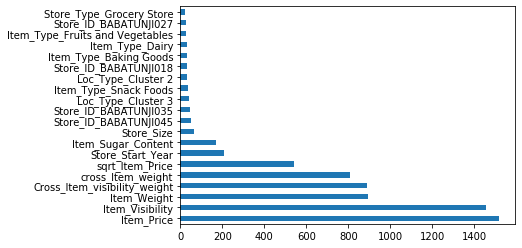

In [48]:
feat_import = pd.Series(lgb.feature_importances_, index = data.columns)
feat_import.sort_values(ascending = False).nlargest(20).plot(kind = 'barh')

In [49]:
# data2 = data.drop(['Item_ID', 'Item_Visibility'], axis = 1)

In [50]:
# test2 = test.drop(['Item_ID', 'Item_Visibility'], axis = 1)

In [51]:
final = lgb_test_pred/30

In [52]:
sub2 = pd.DataFrame(final, columns = ['Item_Store_Returns'])

In [53]:
sub2.head()

,Item_Store_Returns
0,1708.823772
1,8855.520087
2,8919.725739
3,1855.573530
4,7549.825737


In [54]:
sub2['Item_Store_Returns'] = round(sub2['Item_Store_Returns']).astype('int')

In [55]:
sub2.head()

,Item_Store_Returns
0,1709
1,8856
2,8920
3,1856
4,7550


In [56]:
submission = pd.concat([submit, sub2], axis = 1)

In [57]:
submission.head()

,Item_Store_ID,Item_Store_Returns
0,DRA59_BABATUNJI010,1709
1,DRA59_BABATUNJI013,8856
2,DRB01_BABATUNJI013,8920
3,DRB13_BABATUNJI010,1856
4,DRB13_BABATUNJI013,7550


In [58]:
submission.shape

(3532, 2)

In [59]:
submission.to_csv('My_submission2b2.csv', index = False)